In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import random
import os
import h5py
import matplotlib.pyplot as plt
import cv2
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from transformers import AutoModel, AutoProcessor
import gc
from sklearn.decomposition import IncrementalPCA

In [4]:
folder_path = "/content/drive/MyDrive/TVSD_Materials/data"
if os.path.exists(folder_path):
    print(f"Folder exists: {folder_path}")
    print("Files inside:", os.listdir(folder_path))
else:
    print(f"Folder NOT found: {folder_path}")

Folder exists: /content/drive/MyDrive/TVSD_Materials/data
Files inside: ['object_images', 'things_imgs.mat', '_image_database_things.zip', 'THINGS_normMUA_monkey F_mapping.mat', 'monkeyN_THINGS_normMUA_no mapping.mat', 'monkeyF_THINGS_normMUA_no mapping.mat', 'THINGS_normMUA_monkey N_mapping.mat', 'macaquebrain.obj', 'macaque_brain.ply', 'macaque_brain.stl', 'resized_images_64']


In [7]:
#  Set a global seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)  # If using PyTorch models

#  Ensure deterministic behavior in some libraries
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#  Define dataset paths for both monkeys
monkeyF_data_path = "/content/drive/MyDrive/TVSD_Materials/data/THINGS_normMUA_monkey F_mapping.mat"
monkeyN_data_path = "/content/drive/MyDrive/TVSD_Materials/data/THINGS_normMUA_monkey N_mapping.mat"

#  Image Mapping and Image Folder Paths (unchanged)
image_mapping_path = "/content/drive/MyDrive/TVSD_Materials/data/things_imgs.mat"
image_base_path = "/content/drive/MyDrive/TVSD_Materials/data/object_images"


In [9]:
# Load Monkey F and Monkey N MUA Data using h5py


with h5py.File(monkeyN_data_path, 'r') as f:
    train_MUA_N = np.array(f["train_MUA"])
    test_MUA_N = np.array(f["test_MUA"])


print(f" Monkey N - Train MUA Shape: {train_MUA_N.shape}, Test MUA Shape: {test_MUA_N.shape}")


 Monkey N - Train MUA Shape: (22248, 1024), Test MUA Shape: (100, 1024)


In [10]:
import scipy.io

# Load the MUA dataset
mua_monkeyF = scipy.io.loadmat(monkeyF_data_path)

# Print available keys
print("Available keys in the MUA dataset:", mua_monkeyF.keys())

# Extract relevant data
train_MUA_F = mua_monkeyF["train_MUA"]  # Shape: (1024 electrodes x 22,248 stimuli)
test_MUA_F = mua_monkeyF["test_MUA"]  # Shape: (1024 electrodes x 100 stimuli)

print("Train F MUA Shape:", train_MUA_F.shape)
print("Test F MUA Shape:", test_MUA_F.shape)


Available keys in the MUA dataset: dict_keys(['__header__', '__version__', '__globals__', 'SNR', 'lats', 'mapping', 'oracle', 'reliab', 'tb', 'test_MUA', 'test_MUA_reps', 'train_MUA', 'SNR_max'])
Train F MUA Shape: (1024, 22248)
Test F MUA Shape: (1024, 100)


In [11]:
# Open the HDF5 file and inspect the structure
with h5py.File(image_mapping_path, "r") as file:
    train_things_path = file["train_imgs"]["things_path"]
    test_things_path = file["test_imgs"]["things_path"]

    print("🔹 Type of 'things_path' for train set:", type(train_things_path))
    print("🔹 Shape of 'things_path' for train set:", train_things_path.shape)

    # Print raw entries to understand the structure
    print("\n🔹 First 5 raw training entries in 'things_path':", train_things_path[:5])
    print("\n🔹 First 5 raw test entries in 'things_path':", test_things_path[:5])

🔹 Type of 'things_path' for train set: <class 'h5py._hl.dataset.Dataset'>
🔹 Shape of 'things_path' for train set: (22248, 1)

🔹 First 5 raw training entries in 'things_path': [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]

🔹 First 5 raw test entries in 'things_path': [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]


In [13]:
def extract_filenames_from_hdf5(file, dataset_path):
    """
    Correctly extracts filenames stored in an HDF5 dataset.
    Fixes encoding issues and converts Windows paths to Unix-style paths.
    """
    dataset = file[dataset_path]
    filenames = []

    for ref in dataset[:, 0]:  # Iterate over all references in the first column
        try:
            ref_obj = file[ref]
            if isinstance(ref_obj, h5py.Dataset):
                # Decode from UTF-16, remove null bytes, and replace backslashes
                filename = bytes(ref_obj[()]).decode('utf-16').strip().replace('\\', '/')
                filenames.append(filename)
            else:
                filenames.append("Invalid_Reference")
        except Exception as e:
            print(f"Decoding error: {e}")
            filenames.append("Error")

    return filenames

# Inspect HDF5 file structure
def print_hdf5_structure(name, obj):
    print(f"Object Path: {name}, Type: {type(obj)}")

print(" HDF5 File Structure:")
with h5py.File(image_mapping_path, 'r') as f:
    f.visititems(print_hdf5_structure)

# Extract filenames and normalize paths
with h5py.File(image_mapping_path, 'r') as file:
    train_image_filenames = extract_filenames_from_hdf5(file, "train_imgs/things_path")
    test_image_filenames = extract_filenames_from_hdf5(file, "test_imgs/things_path")

print("\n First 5 training set filenames:", train_image_filenames[:5])
print(" First 5 test set filenames:", test_image_filenames[:5])

Streaming output truncated to the last 5000 lines.
Object Path: #refs#/vOh, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vOi, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vOj, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vOk, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vOl, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vOm, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vOn, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vOo, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vOp, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vOq, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vP, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vPb, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vPc, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vPd, Type: <class 'h5py._hl.dataset.Dataset'>
Object Path: #refs#/vPe, T

In [14]:
# Open the file
with h5py.File(image_mapping_path, "r") as file:
    train_things_path = file["train_imgs"]["things_path"]
    test_things_path = file["test_imgs"]["things_path"]

    print(" Type of 'things_path' for train set:", type(train_things_path))
    print(" Shape of 'things_path' for train set:", train_things_path.shape)
    print(" Sample entry type:", type(train_things_path[0]))

    # Print the first five entries to see the raw values
    print("\n First 5 entries in 'things_path':", train_things_path[:5])

 Type of 'things_path' for train set: <class 'h5py._hl.dataset.Dataset'>
 Shape of 'things_path' for train set: (22248, 1)
 Sample entry type: <class 'numpy.ndarray'>

 First 5 entries in 'things_path': [[<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]
 [<HDF5 object reference>]]


In [15]:
#  Generate full paths for training and test images
train_image_paths = [os.path.join(image_base_path, filename) for filename in train_image_filenames]
test_image_paths = [os.path.join(image_base_path, filename) for filename in test_image_filenames]

#  Check if the image files exist
missing_train = [path for path in train_image_paths if not os.path.exists(path)]
missing_test = [path for path in test_image_paths if not os.path.exists(path)]

#  Print verification results
print(f" Total Training Images: {len(train_image_paths)}, Missing: {len(missing_train)}")
print(f" Total Test Images: {len(test_image_paths)}, Missing: {len(missing_test)}")

 Total Training Images: 22248, Missing: 0
 Total Test Images: 100, Missing: 0


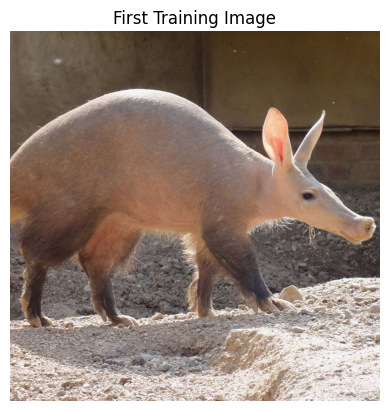

In [ ]:
image_path = train_image_paths[0]

if os.path.exists(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert OpenCV BGR format to RGB
    plt.imshow(img)
    plt.title("First Training Image")
    plt.axis("off")
    plt.show()
else:
    print(f"❌ Image not found: {image_path}")

In [ ]:
# ✅ Define model type and selected layers
model_type = "alexnet"

# ✅ Define image preprocessing steps
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # AlexNet requires 224x224 input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ✅ Load pre-trained AlexNet
alexnet = models.alexnet(pretrained=True)
alexnet.eval()  # Set to inference mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 171MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### 1. Feature Extraction by Layer

In [ ]:
import gc
import numpy as np
import torch
from tqdm import tqdm
import os
from PIL import Image

# ✅ Dictionary to store activations
activations = {}

# ✅ Hook function to store activations
def hook_fn(module, input, output):
    activations[module] = output.cpu().detach().numpy().flatten()

# ✅ Register hooks on all layers
for i, layer in enumerate(alexnet.features):
    layer.register_forward_hook(hook_fn)

# ✅ Function to extract features from all layers
def extract_features_all_layers(image_filenames, base_path, model_type, set_type='train'):
    for i, layer in enumerate(alexnet.features):
        train_save_path = f"/content/drive/MyDrive/saved/{model_type}/features/train_features_{model_type}_layer{i}.npy"
        test_save_path = f"/content/drive/MyDrive/saved/{model_type}/features/test_features_{model_type}_layer{i}.npy"

        # ✅ Skip extraction if files already exist
        if os.path.exists(f"/content/drive/MyDrive/saved/{model_type}/features/{set_type}_features_{model_type}_layer{i}.npy"):
            print(f"✅ Features for layer {i} already exist. Skipping extraction.")
            continue

        features = []

        with tqdm(total=len(image_filenames), desc=f"Extracting Layer {i}", unit="img") as pbar:
            for img_filename in image_filenames:
                img_path = os.path.join(base_path, img_filename)

                if os.path.exists(img_path):
                    img_tensor = transform(Image.open(img_path).convert('RGB')).unsqueeze(0).to(device)
                    with torch.no_grad():
                        alexnet(img_tensor)  # Forward pass to store activations

                    # ✅ Store activations for the current layer
                    features.append(activations[alexnet.features[i]])
                    del activations[alexnet.features[i]]  # ✅ Free up memory
                    gc.collect()

                pbar.update(1)  # ✅ Update tqdm after processing each image

        # ✅ Convert to NumPy array & save
        features = np.array(features)
        if set_type == 'train':
            np.save(train_save_path, features)
        else:
            np.save(test_save_path, features)

        print(f"✅ Saved extracted features for layer {i}")
        print(f"{set_type} features shape: {features.shape}")

        # Garbage collect the features for space
        del features
        gc.collect()  # Force garbage collection

# ✅ Extract Features from All Layers
extract_features_all_layers(train_image_filenames, image_base_path, model_type, set_type='train')
extract_features_all_layers(test_image_filenames, image_base_path, model_type, set_type='test')

✅ Features for layer 0 already exist. Skipping extraction.
✅ Features for layer 1 already exist. Skipping extraction.
✅ Features for layer 2 already exist. Skipping extraction.
✅ Features for layer 3 already exist. Skipping extraction.
✅ Features for layer 4 already exist. Skipping extraction.
✅ Features for layer 5 already exist. Skipping extraction.
✅ Features for layer 6 already exist. Skipping extraction.
✅ Features for layer 7 already exist. Skipping extraction.
✅ Features for layer 8 already exist. Skipping extraction.
✅ Features for layer 9 already exist. Skipping extraction.
✅ Features for layer 10 already exist. Skipping extraction.
✅ Features for layer 11 already exist. Skipping extraction.
✅ Features for layer 12 already exist. Skipping extraction.
✅ Features for layer 0 already exist. Skipping extraction.
✅ Features for layer 1 already exist. Skipping extraction.
✅ Features for layer 2 already exist. Skipping extraction.
✅ Features for layer 3 already exist. Skipping extrac

In [ ]:
# def get_layer_shapes(model_type, set_type):
#     for i, layer in enumerate(alexnet.features):
#         features_path = f"/content/drive/MyDrive/Colab Notebooks/MUA_data/saved/{model_type}/features/{set_type}_features_{model_type}_layer{i}.npy"
#         features = np.load(features_path)
#         print(f'Shape for {set_type} layer {i} for AlexNet: {features.shape}')
#         del features
#         gc.collect()  # Force garbage collection

# # ✅ Get shapes for train and test sets
# get_layer_shapes(model_type, 'train')
# get_layer_shapes(model_type, 'test')

### 2. PCA Extraction

In [ ]:
import numpy as np
import os
import time
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import IncrementalPCA

%config InlineBackend.figure_format = 'retina'  # High-resolution plots

# ✅ Function to find optimal PCA components (default 95% variance)
def find_optimal_components(train_features_path, batch_size=1000, threshold=0.95):
    print(f"🔍 Finding optimal components for {train_features_path}...")

    # ✅ Load dataset as memory-mapped array
    train_features = np.load(train_features_path, mmap_mode='r')

    # ✅ Initialize Incremental PCA
    ipca = IncrementalPCA()
    start_time = time.time()

    # ✅ Fit PCA in mini-batches
    for i in tqdm(range(0, train_features.shape[0], batch_size), desc="Fitting Incremental PCA", unit="batch"):
        batch = train_features[i : i + batch_size].astype(np.float32)  # ✅ Reduce memory usage
        ipca.partial_fit(batch)
        del batch
        gc.collect()  # ✅ Force garbage collection

    duration = (time.time() - start_time) / 60
    print(f"⏳ Duration for Incremental PCA: {duration:.2f} minutes")

    # ✅ Compute cumulative explained variance
    cumulative_variance = np.cumsum(ipca.explained_variance_ratio_)

    # ✅ Find optimal number of components
    if np.any(cumulative_variance >= threshold):
        n_components = np.argmax(cumulative_variance >= threshold) + 1
    else:
        n_components = min(batch_size, len(cumulative_variance))  # ✅ Take max available components

    # ✅ Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, label="Cumulative Explained Variance")
    plt.axhline(y=threshold, color='r', linestyle='--', label=f"{int(threshold * 100)}% Variance Threshold")
    plt.axvline(x=n_components, color='g', linestyle='--', label=f"{n_components} Components")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Explained Variance")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"✅ Optimal number of components for {int(threshold * 100)}% variance: {n_components}")
    return ipca, n_components  # ✅ Return fitted PCA model to avoid re-fitting later

# ✅ Function to perform PCA for each layer and save results
def perform_pca_for_layers(model_type, threshold=0.95, batch_size=1000):
    # Loop through all layers in AlexNet
    for layer_idx, layer in tqdm(enumerate(alexnet.features), desc="Processing Layers for PCA", unit="layer"):
        train_features_path = f"/content/drive/MyDrive/saved/{model_type}/features/train_features_{model_type}_layer{layer_idx}.npy"
        test_features_path = f"/content/drive/MyDrive/saved/{model_type}/features/test_features_{model_type}_layer{layer_idx}.npy"

        train_features_pca_path = f"/content/drive/MyDrive/saved/{model_type}/pca/train_features_pca_{model_type}_layer{layer_idx}.npz"
        test_features_pca_path = f"/content/drive/MyDrive/saved/{model_type}/pca/test_features_pca_{model_type}_layer{layer_idx}.npz"

        # ✅ Skip PCA computation if already exists
        if os.path.exists(train_features_pca_path) and os.path.exists(test_features_pca_path):
            print(f"✅ PCA features for layer {layer_idx} already exist. Skipping computation.")
            continue

        # ✅ Find optimal number of PCA components (returns fitted PCA model)
        ipca, n_components = find_optimal_components(train_features_path, batch_size, threshold)

        print(f"🔄 Performing Incremental PCA on layer {layer_idx} with {n_components} components...")

        # ✅ Load dataset as memory-mapped arrays
        train_features = np.load(train_features_path, mmap_mode='r').astype(np.float32) # ✅ Convert to float32 to save memory
        test_features = np.load(test_features_path, mmap_mode='r').astype(np.float32)

        # ✅ Process train data in batches
        train_features_pca = []
        for i in tqdm(range(0, train_features.shape[0], batch_size), desc="Transforming Train Data", unit="batch"):
            batch = train_features[i : i + batch_size]
            train_features_pca.append(ipca.transform(batch))
            del batch
            gc.collect()  # ✅ Force garbage collection

        # ✅ Process test data in batches
        test_features_pca = []
        for i in tqdm(range(0, test_features.shape[0], batch_size), desc="Transforming Test Data", unit="batch"):
            batch = test_features[i : i + batch_size]
            test_features_pca.append(ipca.transform(batch))
            del batch
            gc.collect()  # ✅ Force garbage collection

        # ✅ Convert lists to NumPy arrays and save compressed files
        np.savez_compressed(train_features_pca_path, np.vstack(train_features_pca))
        np.savez_compressed(test_features_pca_path, np.vstack(test_features_pca))

        print(f"✅ Saved PCA-transformed features for layer {layer_idx}")

        # ✅ Free up memory after each layer
        del train_features, test_features, train_features_pca, test_features_pca, ipca
        gc.collect()  # ✅ Force garbage collection

# ✅ Perform PCA for each layer
perform_pca_for_layers(model_type)

Processing Layers for PCA: 13layer [00:03,  3.48layer/s]

✅ PCA features for layer 0 already exist. Skipping computation.
✅ PCA features for layer 1 already exist. Skipping computation.
✅ PCA features for layer 2 already exist. Skipping computation.
✅ PCA features for layer 3 already exist. Skipping computation.
✅ PCA features for layer 4 already exist. Skipping computation.
✅ PCA features for layer 5 already exist. Skipping computation.
✅ PCA features for layer 6 already exist. Skipping computation.
✅ PCA features for layer 7 already exist. Skipping computation.
✅ PCA features for layer 8 already exist. Skipping computation.
✅ PCA features for layer 9 already exist. Skipping computation.
✅ PCA features for layer 10 already exist. Skipping computation.
✅ PCA features for layer 11 already exist. Skipping computation.
✅ PCA features for layer 12 already exist. Skipping computation.


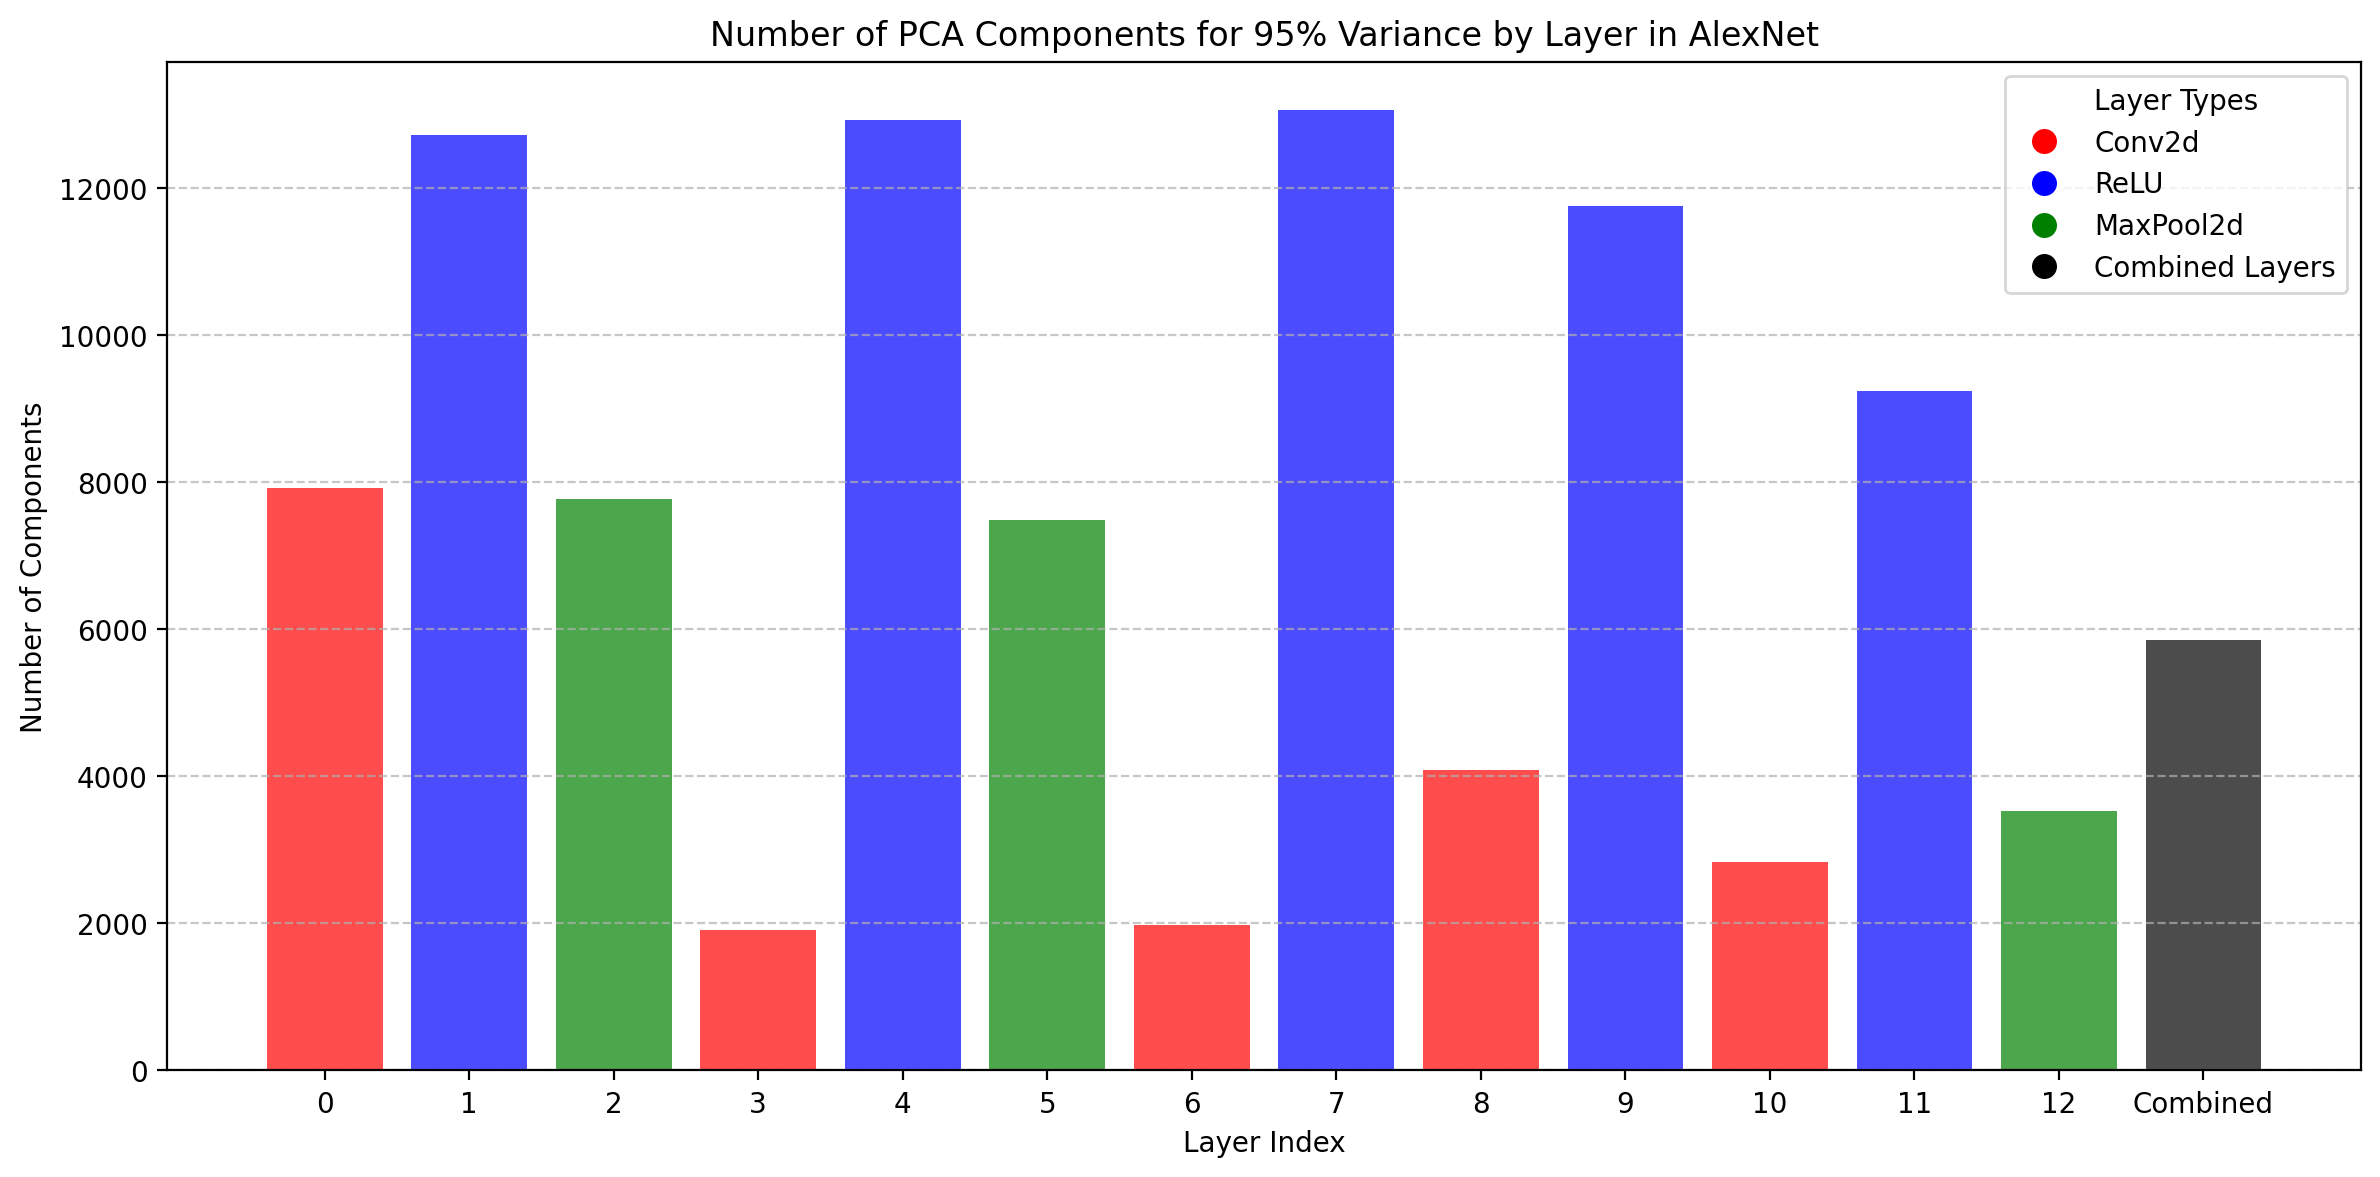

In [ ]:
import torch
import matplotlib.pyplot as plt
from collections import OrderedDict

# Assuming alexnet is your model
# Get the layers of the 'features' part of AlexNet
layer_names = []
num_components_pca = []
num_components_pca_values = [7915, 12721, 7771, 1905, 12931, 7490, 1984, 13066, 4081, 11752, 2839, 9242, 3527] # Found manually from fitting PCA

# Add the combined features bar with 5848 components (black bar)
num_components_pca_values.append(5848)


# Color map based on layer types
layer_colors = {
    'Conv2d': 'red',       # Conv2d layers in red
    'ReLU': 'blue',        # ReLU layers in blue
    'MaxPool2d': 'green',  # MaxPool2d layers in green
    'Combined': 'black'    # Combined features in black
}

# Store layer types and corresponding colors
colors = []

for idx, (name, layer) in enumerate(alexnet.features.named_children()):
    # Store the layer names
    layer_names.append(name)

    # Retrieve the corresponding number of PCA components
    num_components_pca.append(num_components_pca_values[idx])  # Replace with actual PCA results

    # Get the type of the layer and map it to a color
    layer_type = type(layer).__name__
    if layer_type in layer_colors:
        colors.append(layer_colors[layer_type])
    else:
        colors.append('gray')  # Default color for unknown layer types

# Add combined features
num_components_pca.append(5848)
layer_names.append("Combined")
colors.append('black')

# Bar plot for the number of components per layer
plt.figure(figsize=(12, 6))

# Create a bar plot with color coding
bars = plt.bar(layer_names, num_components_pca, color=colors, alpha=0.7)

# Add the legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Conv2d'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='ReLU'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='MaxPool2d'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Combined Layers')]

plt.legend(handles=legend_elements, title="Layer Types")

plt.title("Number of PCA Components for 95% Variance by Layer in AlexNet")
plt.xlabel("Layer Index")
plt.ylabel("Number of Components")
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # To ensure everything fits well
plt.show()

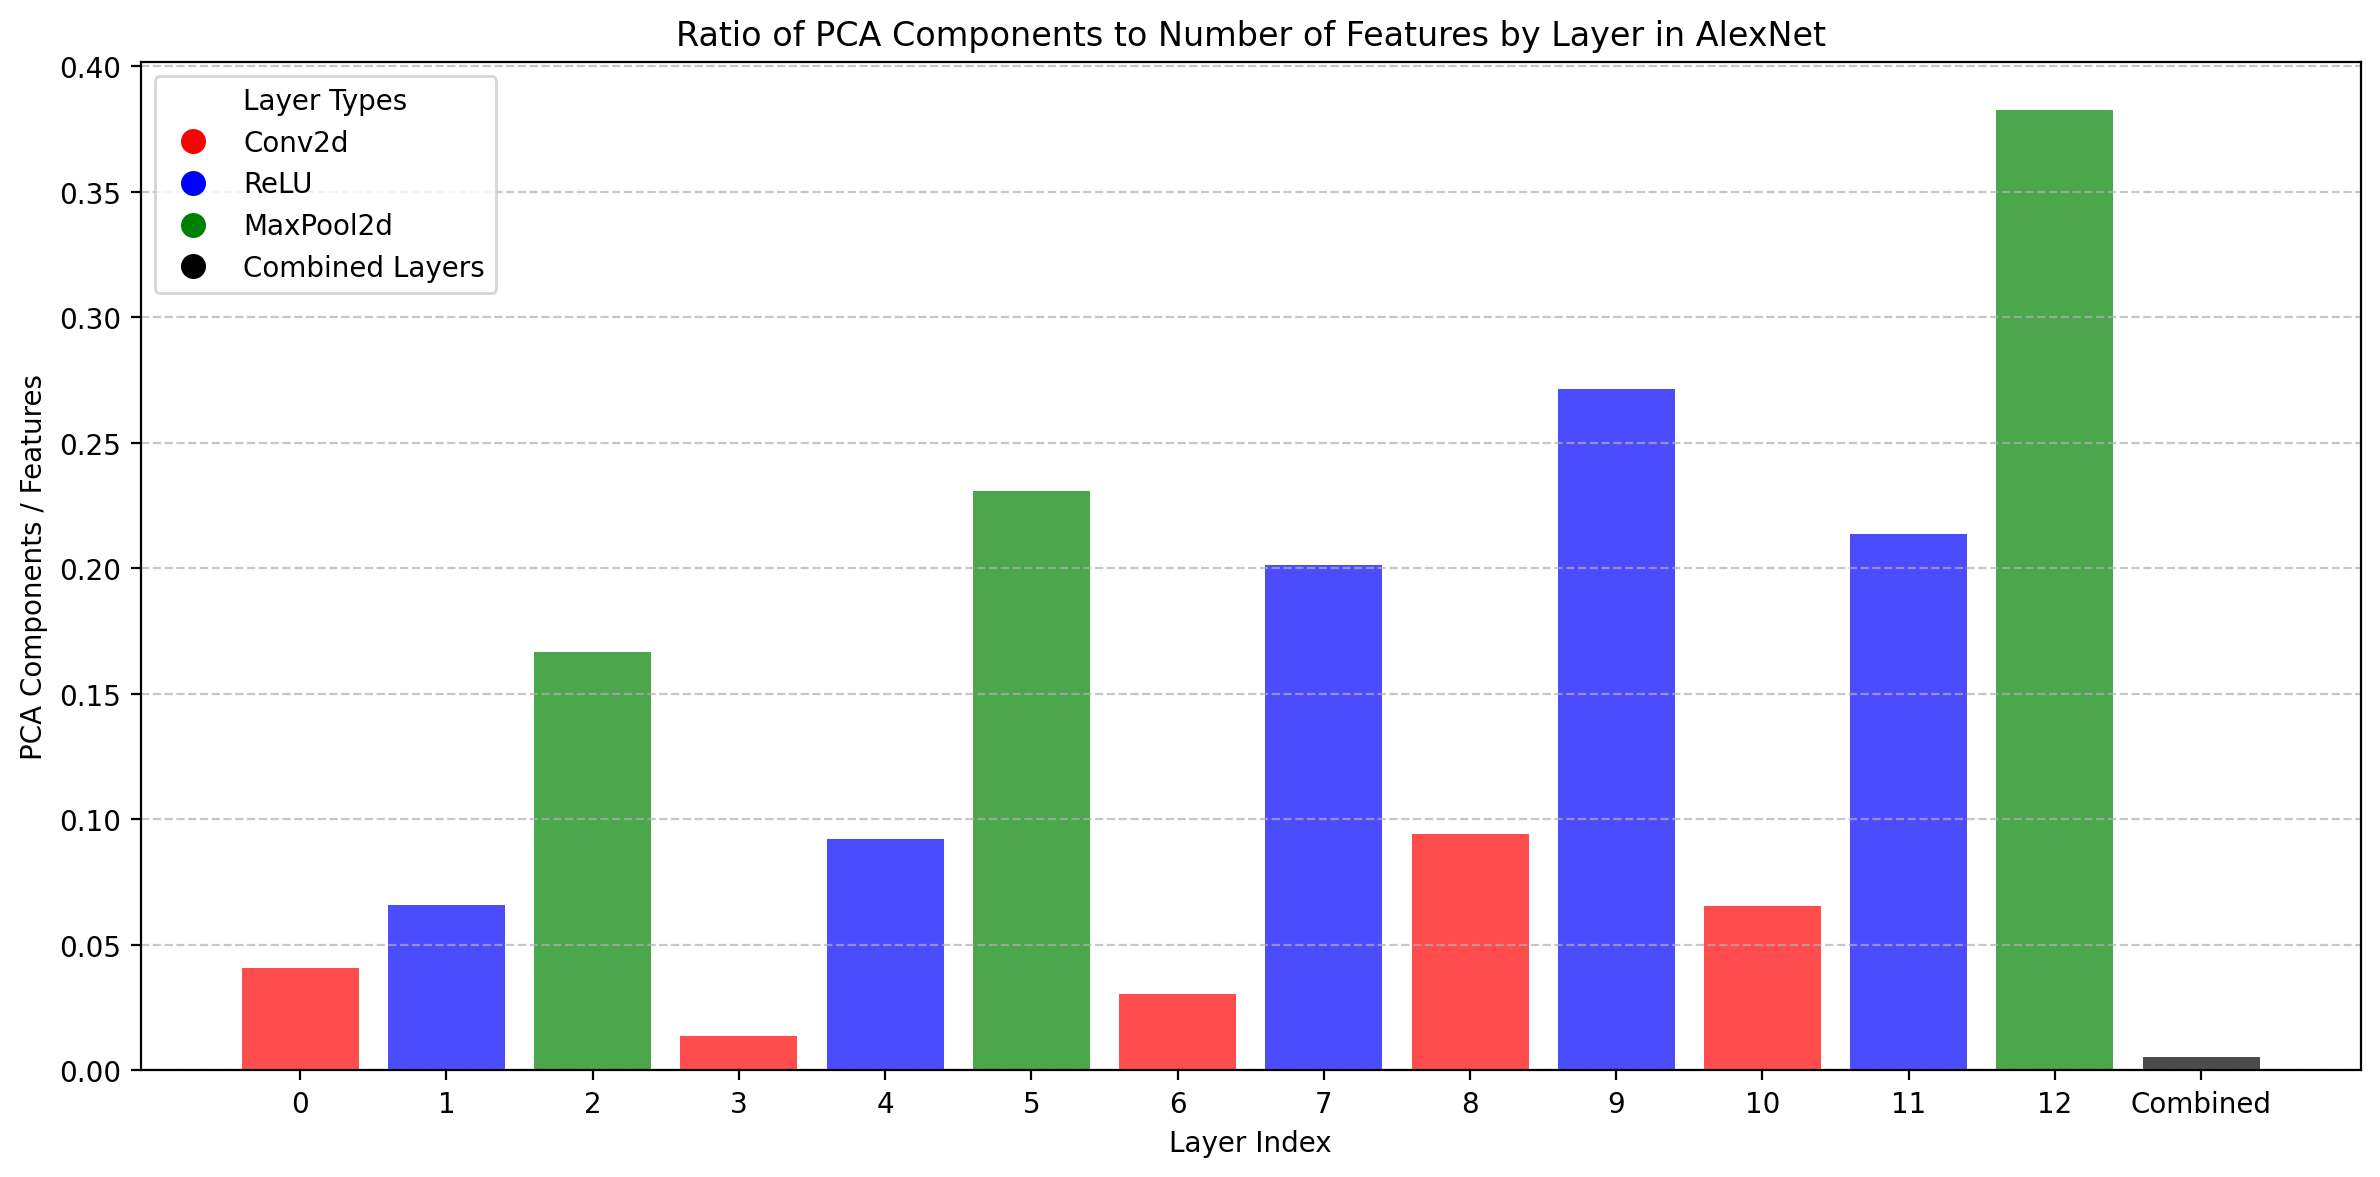

In [ ]:
import torch
import matplotlib.pyplot as plt
from collections import OrderedDict
from matplotlib.lines import Line2D

# Assuming alexnet is your model
# Layer shapes for AlexNet (as you provided)
layer_shapes = [
    (193600), (193600), (46656), (139968), (139968),
    (32448), (64896), (64896), (43264), (43264),
    (43264), (43264), (9216)
]

layer_shapes.append(sum(layer_shapes))

# Calculating the ratio of PCA components to number of features
ratio_pca_to_features = [num / shape for num, shape in zip(num_components_pca, layer_shapes)]

# Layer colors based on type
layer_colors = {
    'Conv2d': 'red',       # Conv2d layers in red
    'ReLU': 'blue',        # ReLU layers in blue
    'MaxPool2d': 'green',   # MaxPool2d layers in green
    'Combined': 'black'
}

# Store layer types and corresponding colors
colors = []

for idx, (name, layer) in enumerate(alexnet.features.named_children()):
    layer_type = type(layer).__name__
    if layer_type in layer_colors:
        colors.append(layer_colors[layer_type])
    else:
        colors.append('gray')  # Default color for unknown layer types


colors.append('black')

# Bar plot for the ratio of PCA components to features
plt.figure(figsize=(12, 6))

# Create a bar plot with color coding
bars = plt.bar(layer_names, ratio_pca_to_features, color=colors, alpha=0.7)

# Add the legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Conv2d'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='ReLU'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='MaxPool2d'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Combined Layers')]

plt.legend(handles=legend_elements, title="Layer Types")

plt.title("Ratio of PCA Components to Number of Features by Layer in AlexNet")
plt.xlabel("Layer Index")
plt.ylabel("PCA Components / Features")
plt.xticks(rotation=0)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # To ensure everything fits well
plt.show()

In [ ]:
print("train_MUA_F shape:", train_MUA_F.shape)  # should be (1024, 22248)
print("test_MUA_F shape:", test_MUA_F.shape)    # should be (1024, 100)

train_MUA_F shape: (1024, 22248)
test_MUA_F shape: (1024, 100)


### 3. Results + Analysis

In [ ]:
import joblib
import os
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

# ✅ Fix: Transpose the MUA matrices to have (1024, 22248)
train_MUA_F = train_MUA_F.T  # Now shape is (1024, 22248)
train_MUA_N = train_MUA_N.T  # Now shape is (1024, 22248)
print(f"train_MUA_F shape: {train_MUA_F.shape}")  # Expected: (1024, 22248)
print(f"train_MUA_N shape: {train_MUA_N.shape}")  # Expected: (1024, 22248)

# print("🔎 Checking test MUA shapes:")
# print(f"test_MUA_F shape: {test_MUA_F.shape}")  # Expected: (100, 1024)
# print(f"test_MUA_N shape: {test_MUA_N.shape}")  # Expected: (100, 1024)
test_MUA_F = test_MUA_F.T
test_MUA_N = test_MUA_N.T
print(f"test_MUA_F shape after T: {test_MUA_F.shape}")  # Expected: (1024, 100)
print(f"test_MUA_N shape after T: {test_MUA_N.shape}")  # Expected: (1024, 100)

# ✅ Train & Predict for Each Layer Separately
for layer_idx, layer in tqdm(enumerate(alexnet.features), desc="Processing Layers", unit="layer"):

    # ✅ Define paths for PCA features
    train_features_pca_path = f"/content/drive/MyDrive/saved/{model_type}/pca/train_features_pca_{model_type}_layer{layer_idx}.npz"
    test_features_pca_path = f"/content/drive/MyDrive/saved/{model_type}/pca/test_features_pca_{model_type}_layer{layer_idx}.npz"

    # ✅ Define paths for trained models or paths to save models on Google Drive
    model_F_save_path = f"/content/drive/MyDrive/saved/{model_type}/model/trained_models_F_{model_type}_layer{layer_idx}.pkl"
    model_N_save_path = f"/content/drive/MyDrive/saved/{model_type}/model/trained_models_N_{model_type}_layer{layer_idx}.pkl"

    # ✅ Skip if PCA features are missing
    if not os.path.exists(train_features_pca_path) or not os.path.exists(test_features_pca_path):
        print(f"⚠ PCA features missing for layer {layer_idx}. Skipping...")
        continue

    # ✅ Load PCA-transformed features
    # train_features_pca = np.load(train_features_pca_path)
    # test_features_pca = np.load(test_features_pca_path)

    # Load the npz file
    train_features_pca_loaded = np.load(train_features_pca_path)
    test_features_pca_loaded = np.load(test_features_pca_path)

    # Extract the arrays using .f
    train_features_pca = train_features_pca_loaded["arr_0"]
    test_features_pca = test_features_pca_loaded["arr_0"]

    # ✅ Debugging Shapes
    print(f"\n🔎 Layer {layer} Debugging Shapes Before Training:")
    print(f"train_features_pca shape: {train_features_pca.shape}")  # Expected: (22248, n_components)
    print(f"test_features_pca shape: {test_features_pca.shape}")  # Expected: (100, n_components)

    # ✅ Check if models exist (to skip retraining)
    if os.path.exists(model_F_save_path) and os.path.exists(model_N_save_path):
        print(f"✅ Loading pre-trained models for Monkey F and Monkey N at layer {layer}...")
        models_F = joblib.load(model_F_save_path)
        models_N = joblib.load(model_N_save_path)
    else:
        # ✅ Train models separately for Monkey F and Monkey N
        print(f"🔄 Training Models for Monkey F and Monkey N at layer {layer}...")

        models_F = [LinearRegression().fit(train_features_pca, train_MUA_F[i, :]) for i in tqdm(range(train_MUA_F.shape[0]), desc=f"Training Models (Monkey F) - Layer {layer}", unit="model")]
        models_N = [LinearRegression().fit(train_features_pca, train_MUA_N[i, :]) for i in tqdm(range(train_MUA_N.shape[0]), desc=f"Training Models (Monkey N) - Layer {layer}", unit="model")]
        print(f"✅ Models saved successfully for layer {layer}:\n{model_F_save_path}\n{model_N_save_path}")
        print(f"✅ Loaded {len(models_F)} models for Monkey F")  # Should be 1024
        print(f"✅ Loaded {len(models_N)} models for Monkey N")  # Should be 1024

        # ✅ Save trained models
        joblib.dump(models_F, model_F_save_path)
        joblib.dump(models_N, model_N_save_path)
        print(f"✅ Models saved successfully for layer {layer}:\n{model_F_save_path}\n{model_N_save_path}")

    # ✅ Predict test MUA responses
    predicted_test_MUA_F = np.array([models_F[i].predict(test_features_pca) for i in range(train_MUA_F.shape[1])])
    predicted_test_MUA_N = np.array([models_N[i].predict(test_features_pca) for i in range(train_MUA_N.shape[0])])

    # ✅ Debug Output
    print(f"\n✅ Prediction Shapes for Layer {layer}:")
    print(f"Predicted MUA F Shape: {predicted_test_MUA_F.shape}")  # Expected: (1024, 100)
    print(f"Predicted MUA N Shape: {predicted_test_MUA_N.shape}")  # Expected: (1024, 100)

train_MUA_F shape: (22248, 1024)
train_MUA_N shape: (1024, 22248)
test_MUA_F shape after T: (100, 1024)
test_MUA_N shape after T: (1024, 100)


Processing Layers: 0layer [00:00, ?layer/s]


🔎 Layer Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))...


Processing Layers: 1layer [00:15, 15.33s/layer]


✅ Prediction Shapes for Layer Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer ReLU(inplace=True) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer ReLU(inplace=True)...


Processing Layers: 2layer [00:28, 14.30s/layer]


✅ Prediction Shapes for Layer ReLU(inplace=True):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)...


Processing Layers: 3layer [00:40, 12.94s/layer]


✅ Prediction Shapes for Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))...


Processing Layers: 4layer [00:54, 13.27s/layer]


✅ Prediction Shapes for Layer Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer ReLU(inplace=True) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer ReLU(inplace=True)...


Processing Layers: 5layer [01:05, 12.69s/layer]


✅ Prediction Shapes for Layer ReLU(inplace=True):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)...


Processing Layers: 6layer [01:15, 11.80s/layer]


✅ Prediction Shapes for Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))...


Processing Layers: 7layer [01:29, 12.60s/layer]


✅ Prediction Shapes for Layer Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer ReLU(inplace=True) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer ReLU(inplace=True)...


Processing Layers: 8layer [01:42, 12.70s/layer]


✅ Prediction Shapes for Layer ReLU(inplace=True):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))...


Processing Layers: 9layer [01:56, 13.03s/layer]


✅ Prediction Shapes for Layer Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer ReLU(inplace=True) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer ReLU(inplace=True)...


Processing Layers: 10layer [02:08, 12.57s/layer]


✅ Prediction Shapes for Layer ReLU(inplace=True):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))...


Processing Layers: 11layer [02:21, 12.79s/layer]


✅ Prediction Shapes for Layer Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer ReLU(inplace=True) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer ReLU(inplace=True)...


Processing Layers: 12layer [02:33, 12.40s/layer]


✅ Prediction Shapes for Layer ReLU(inplace=True):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)

🔎 Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False) Debugging Shapes Before Training:
train_features_pca shape: (22248, 1000)
test_features_pca shape: (100, 1000)
✅ Loading pre-trained models for Monkey F and Monkey N at layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)...


Processing Layers: 13layer [02:48, 12.95s/layer]


✅ Prediction Shapes for Layer MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False):
Predicted MUA F Shape: (1024, 100)
Predicted MUA N Shape: (1024, 100)


In [ ]:
#--- Define the electrode mapping manually using Utah array layout ---
ranges = [
    (33, 128), (1, 32), (161, 256), (129, 160),
    (289, 384), (257, 288), (417, 512), (385, 416),
    (577, 608), (545, 576), (513, 544), (609, 640),
    (705, 736), (673, 704), (641, 672), (737, 768),
    (833, 864), (801, 832), (769, 800), (865, 896),
    (961, 992), (929, 960), (897, 928), (993, 1024)
]
mapping_2 = np.concatenate([np.arange(start, end + 1) for start, end in ranges]) - 1  # Convert to 0-based
# mapping = mapping -1

In [ ]:
mapping = mua_monkeyF["mapping"]
mapping_flat = mapping.flatten()
mapping_flat = mapping_flat -1 # Convert to 0-based
print(mapping_flat)
# np.set_printoptions(threshold=np.inf)  # Remove truncation limit
# print(mua_monkeyF["mapping"])

[  32   33   34 ... 1021 1022 1023]


1.Loads SNR data across 4 days for Monkey F and Monkey N.

2.Averages the SNRs across days → gives a single value per electrode.

3.Uses a mapping to reorder electrodes based on the physical layout of the Utah array.

4.Divides the electrodes into brain regions (V1, V4, IT) using index-based slicing.

5.Groups electrodes in each region into 8x8 arrays for heatmap visualization.

In [ ]:
# --- Open the HDF5 file and compute per-electrode SNR average ---
# with h5py.File(monkeyF_data_path, "r") as f:
#     snr_F = np.array(f["SNR"])         # Load SNR array of shape (4 days, 1024 electrodes)
#     snrF_mean = snr_F.mean(axis=0)     # Compute mean SNR across 4 days → shape: (1024,)
snr_F = mua_monkeyF["SNR"]
snr_F = snr_F.T
snrF_mean = snr_F.mean(axis=0)

with h5py.File(monkeyN_data_path, "r") as f:
    snr_N = np.array(f["SNR"])         # Load SNR array of shape (4 days, 1024 electrodes)
    snrN_mean = snr_N.mean(axis=0)     # Compute mean SNR across 4 days → shape: (1024,)

In [ ]:
print(snr_F.shape)
print(snr_N.shape)

(4, 1024)
(4, 1024)


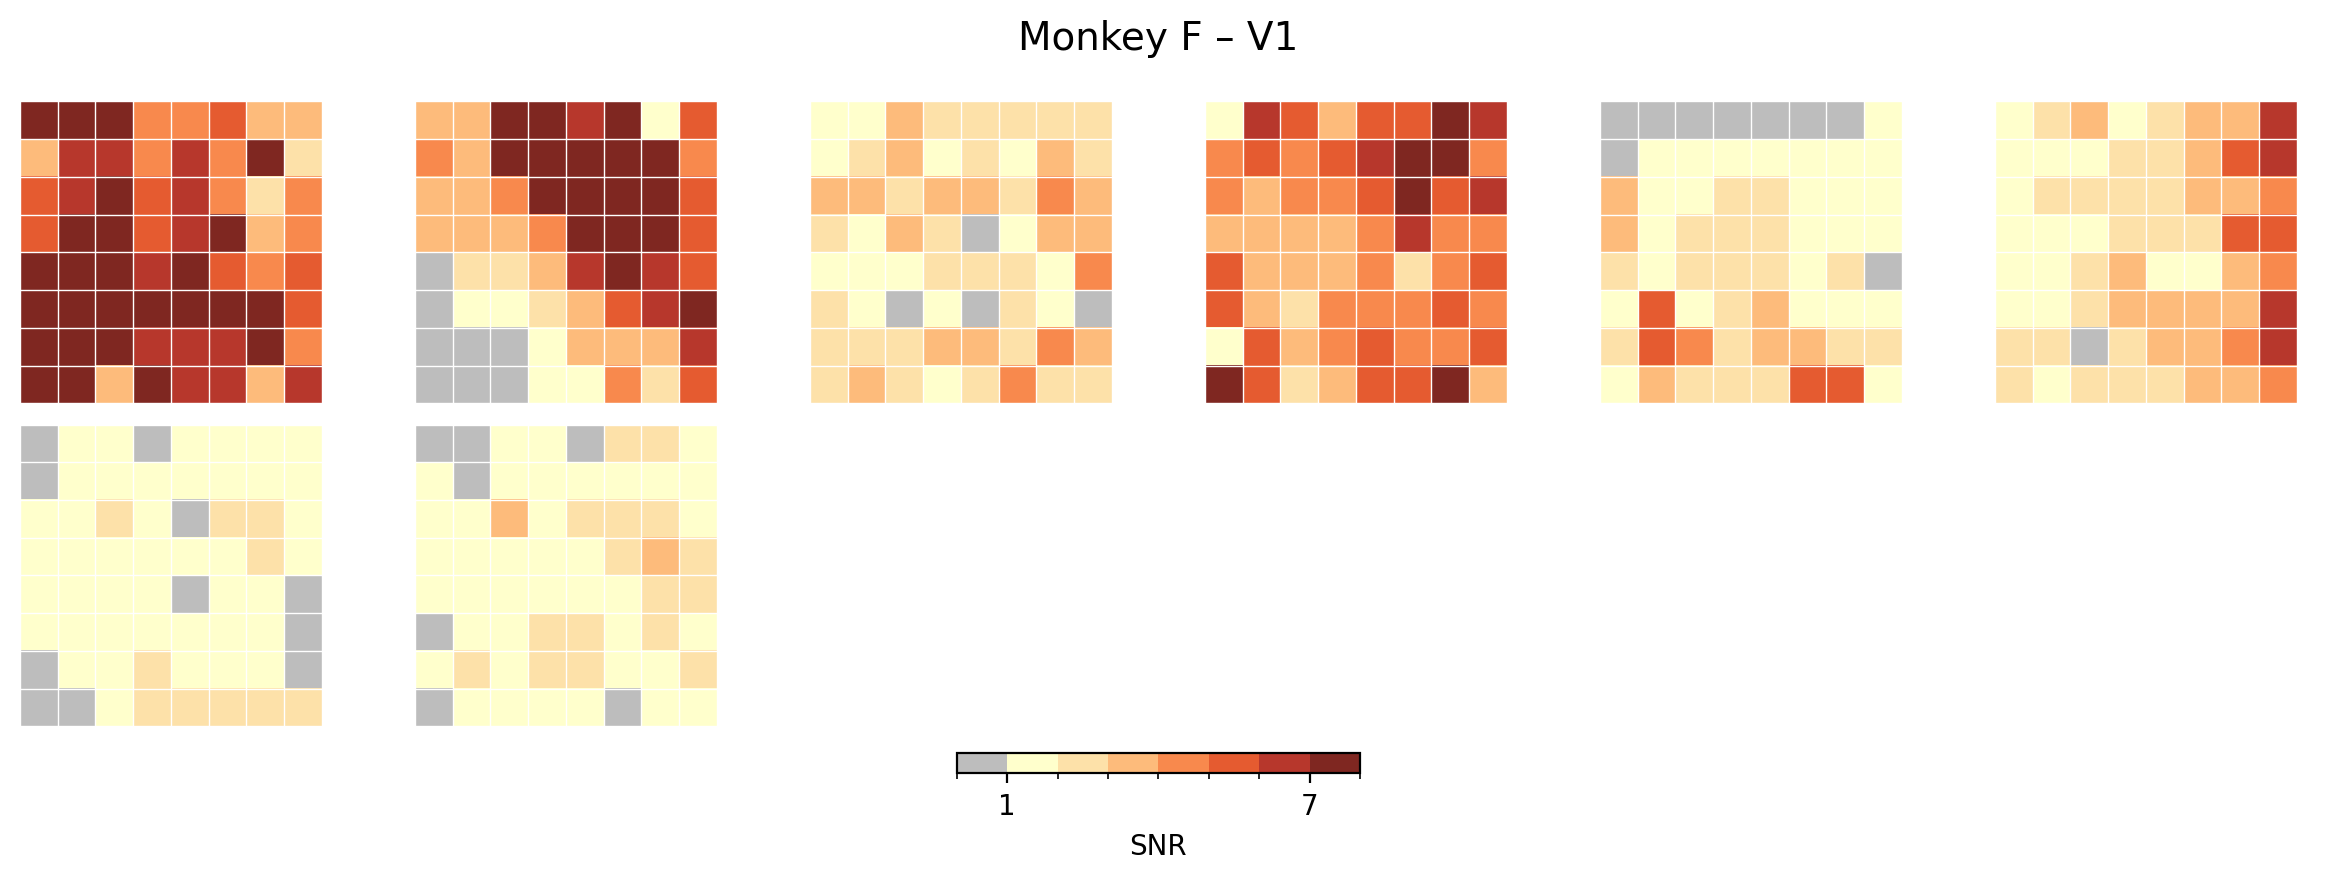

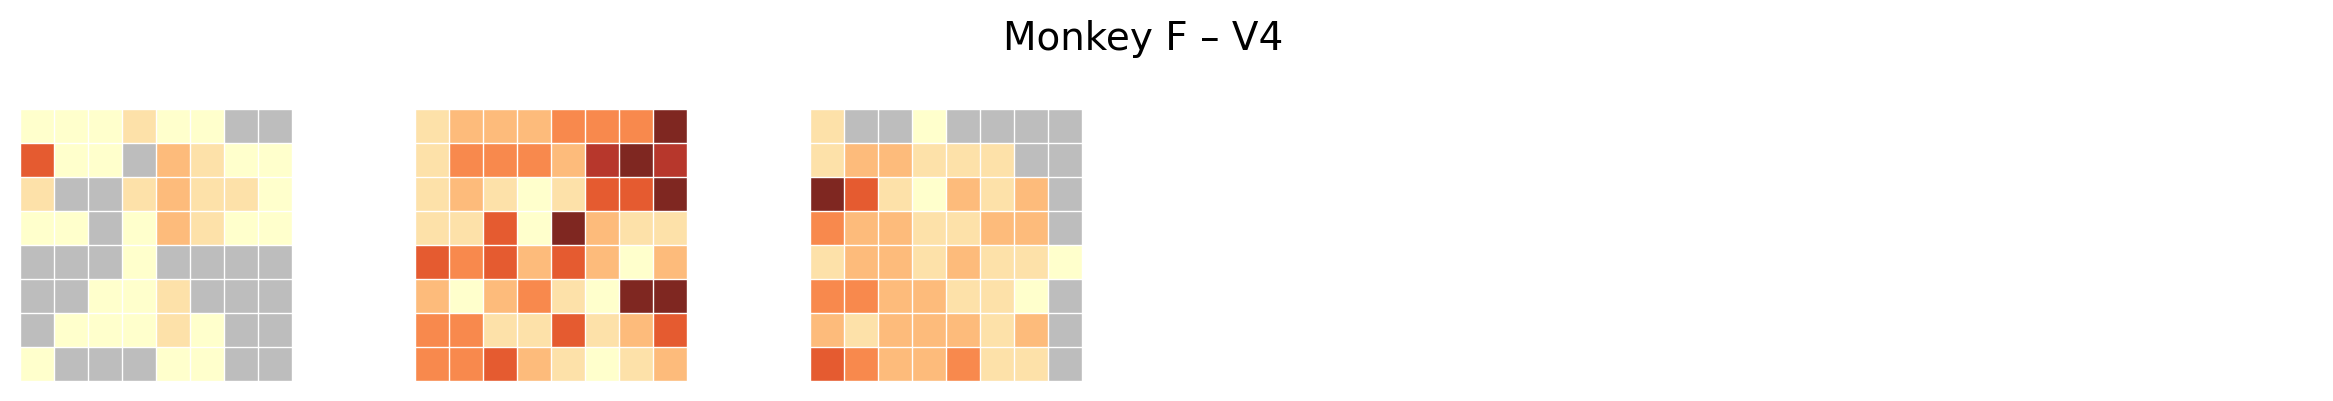

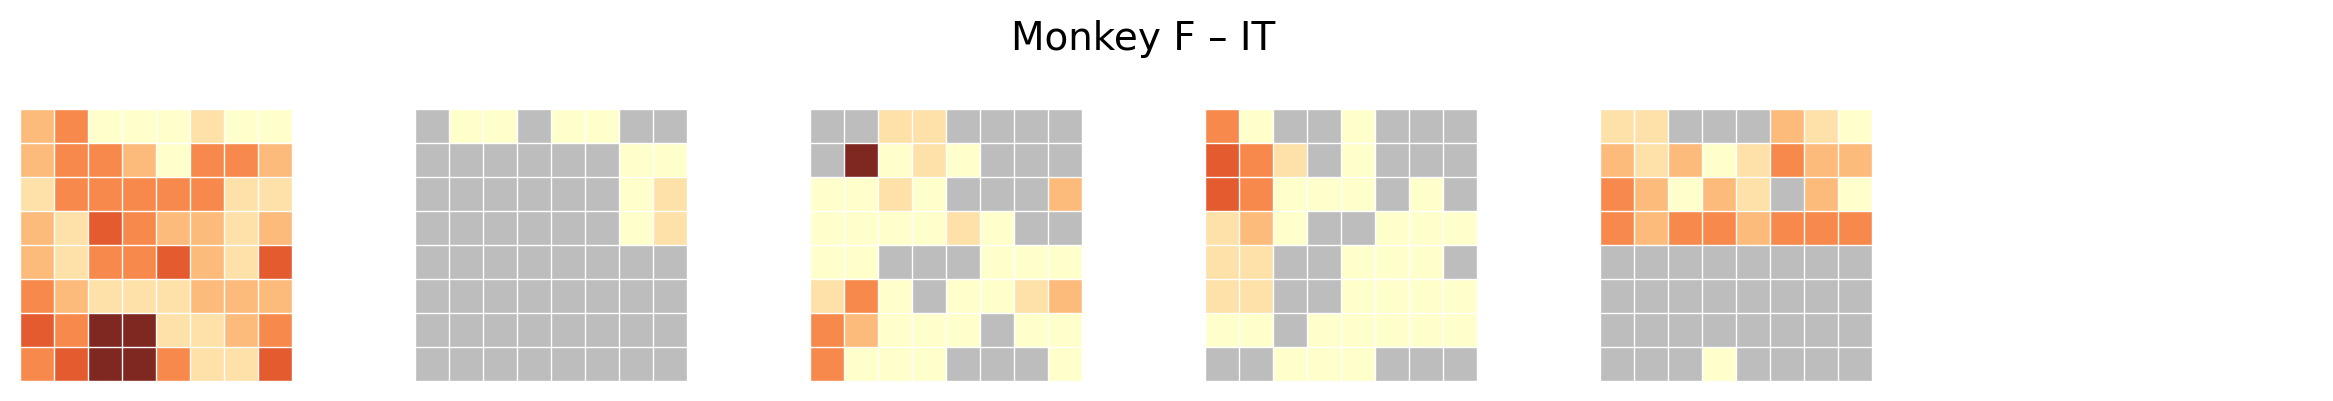

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# --- Reorder SNR values based on physical array layout ---
#snrF_mapped = snrF_mean[mapping]  # Apply mapping so that electrode layout matches physical grid


# --- Create region labels for each electrode: 0 = V1, 1 = V4, 2 = IT ---
# rois_F = np.zeros(1024, dtype=int)        # Initialize all as V1 (0)
# rois_F[512:704] = 1                       # Set V4 (1) for channels 512–703
# rois_F[704:1024] = 2                      # Set IT (2) for channels 704–1023
# rois_F = rois_F[mapping]                 # Reorder the ROI labels using the same mapping

# region_labels_F = np.array(["V1", "V4", "IT"])         # Map numeric ROI to string labels
# reordered_labels_F = region_labels_F[rois_F]           # Convert integer ROI to label strings
rois_F = np.ones(1024, dtype=int)
rois_F[512:832] = 3                       # 1 = V4
rois_F[832:1024] = 2                      # 2 = IT
rois_F = rois_F[mapping_flat]                 # Reorder using mapping
region_labels_F = np.array(["V1", "V4", "IT"])
reordered_labels_F = region_labels_F[rois_F-1]




# --- Create boolean masks for selecting electrodes by region ---
roi_mask_V1 = reordered_labels_F == "V1"
roi_mask_V4 = reordered_labels_F == "V4"
roi_mask_IT = reordered_labels_F == "IT"


# --- Convert each region's SNRs into a list of 8x8 grid heatmaps ---
def extract_roi_grids(snr_values, roi_mask):
    snr_roi = snr_values[roi_mask]                   # Filter SNRs by region
    num_arrays = len(snr_roi) // 64                  # Number of 8x8 arrays
    return [np.fliplr(snr_roi[i * 64:(i + 1) * 64].reshape(8, 8)) for i in range(num_arrays)]
    #return [snr_roi[i * 64:(i + 1) * 64].reshape(8, 8, order='F') for i in range(num_arrays)]


v1_grids = extract_roi_grids(snrF_mean, roi_mask_V1)
v4_grids = extract_roi_grids(snrF_mean, roi_mask_V4)
it_grids = extract_roi_grids(snrF_mean, roi_mask_IT)


# --- Define custom SNR colormap (gray → yellow → orange → dark brown) ---
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- Custom 8-color SNR colormap: gray + 7 steps from yellow to brown ---
snr_colors = [
    "#BDBDBD",  # gray for SNR < 1
    "#FFFFCC",
    "#FDE1A9",
    "#FDBB7B",
    "#F8894D",
    "#E55B30",
    "#B7372C",
    "#7F2721"   # dark brown
]
snr_cmap = ListedColormap(snr_colors)
snr_bounds = np.linspace(0, 8, 9)  # Edges: [0-1), [1-2), ..., [7-8)
snr_norm = BoundaryNorm(snr_bounds, snr_cmap.N)

# --- Function to plot 8x8 arrays with SNR colormap ---
def plot_array_grid(grids, title, ncols=6, show_colorbar=False):
    n = len(grids)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    axs = axs.flatten()

    for i in range(n):
        ax = axs[i]
        im = ax.imshow(grids[i], cmap=snr_cmap, norm=snr_norm, interpolation='none')

        # Add white gridlines
        ax.set_xticks(np.arange(-0.5, 8, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 8, 1), minor=True)
        ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)

        # Hide ticks and labels
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

        # Remove black border around each subplot
        for spine in ax.spines.values():
            spine.set_visible(False)

    for j in range(n, len(axs)):
        axs[j].axis("off")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()

    if show_colorbar:
        cbar = fig.colorbar(im, ax=axs.tolist(), orientation="horizontal", fraction=0.03, pad=0.04)
        cbar.set_label("SNR")
        cbar.set_ticks([1, 7])

    return fig, axs, im


# --- Plot for V1, V4, IT, colorbar on the first one only ---
fig1, axs1, im1 = plot_array_grid(v1_grids, "Monkey F – V1", show_colorbar=True)
fig2, axs2, _ = plot_array_grid(v4_grids, "Monkey F – V4")
fig3, axs3, _ = plot_array_grid(it_grids, "Monkey F – IT")

plt.show()

Steps for MonkeyN

1.Loads SNR data across 4 days for and Monkey N.

2.Averages the SNRs across days → gives a single value per electrode.

4.Divides the electrodes into brain regions (V1, V4, IT) using index-based slicing.

5.Groups electrodes in each region into 8x8 arrays for heatmap visualization.

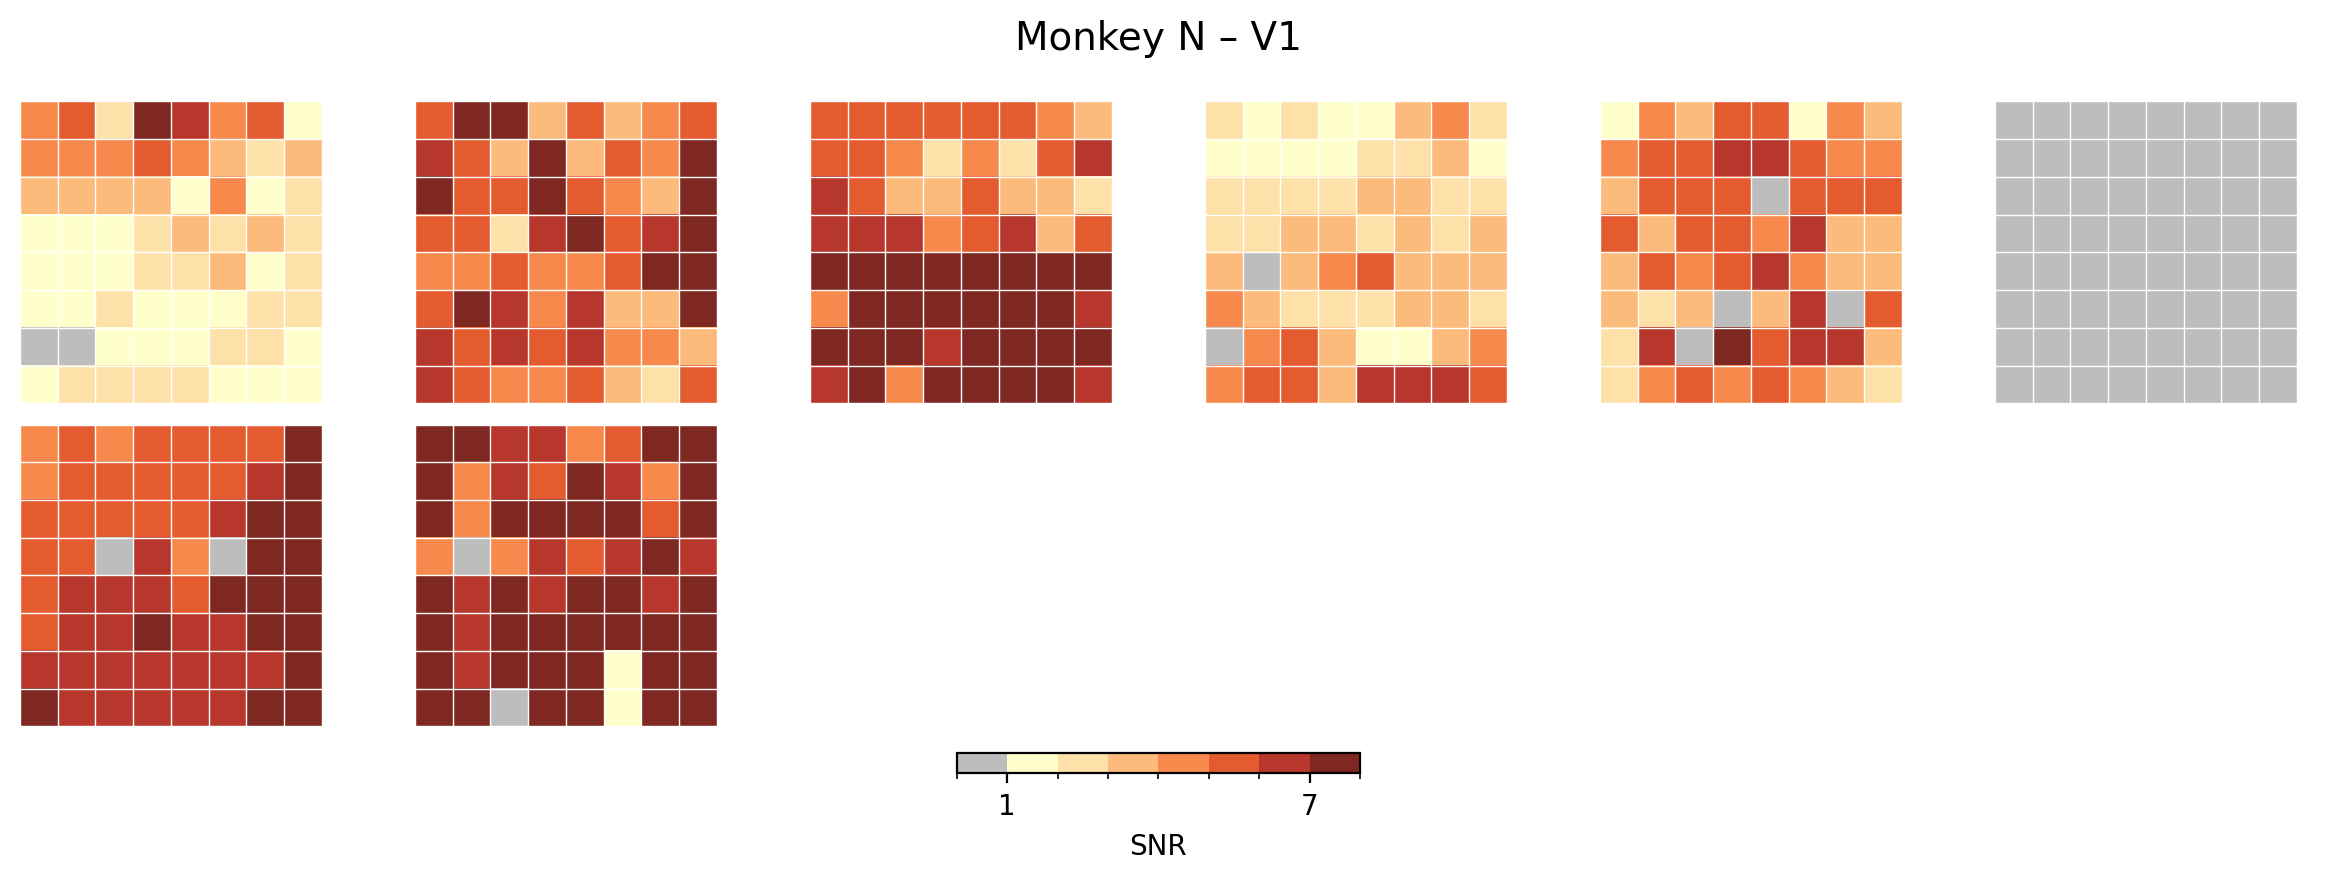

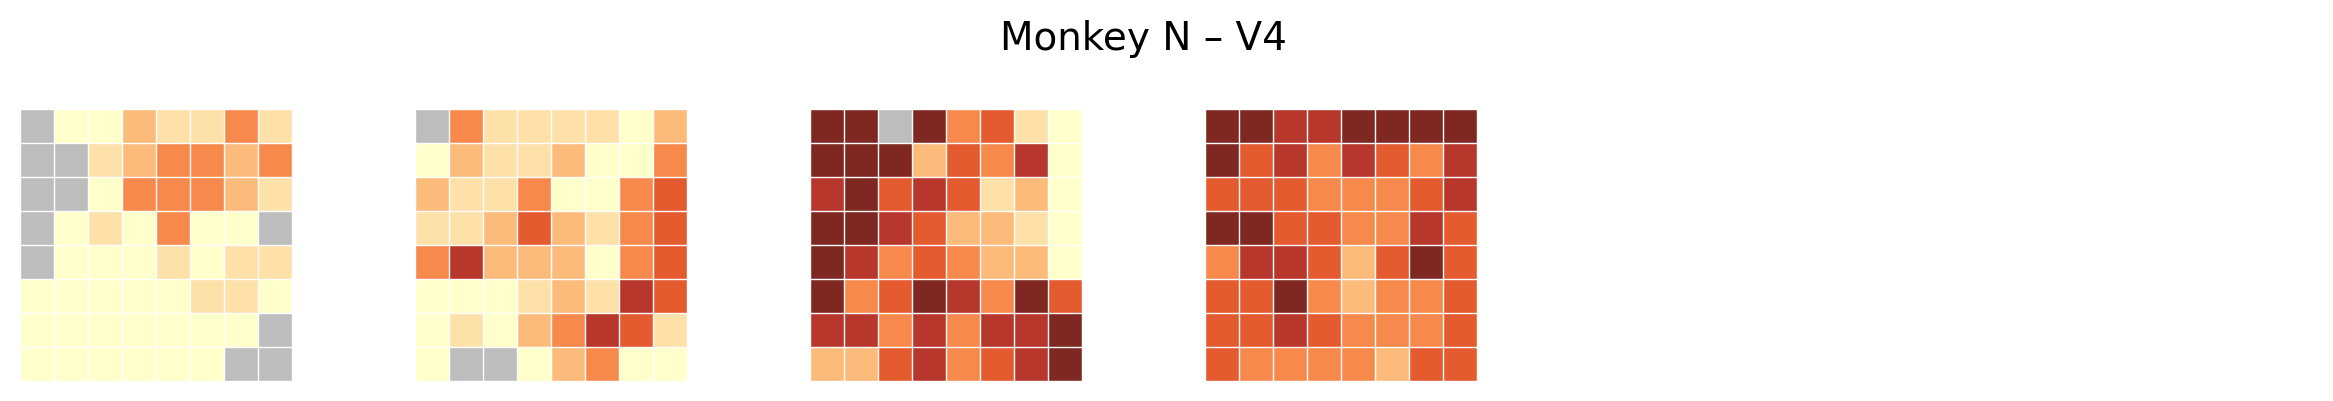

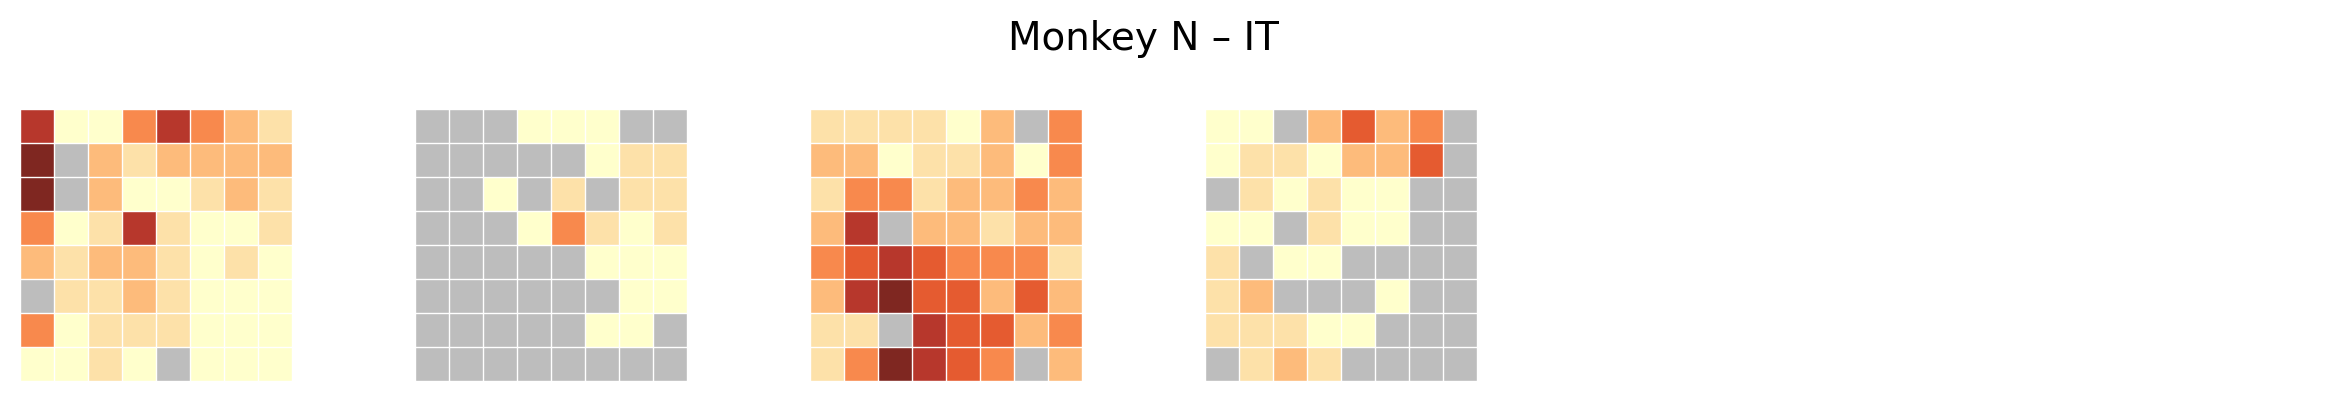

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# --- Reorder SNR values based on physical array layout ---
#snrN_mapped = snrN_mean[mapping]  # Apply mapping so that electrode layout matches physical grid


# --- Create region labels for each electrode: 0 = V1, 1 = V4, 2 = IT ---
rois_N = np.ones(1024, dtype=int)         # 1 = V1
rois_N[512:768] = 2                      # 2 = V4
rois_N[768:1024] = 3                      # 3 = IT
#rois_N = rois_N[mapping]                 # Reorder using mapping

region_labels_N = np.array(["V1", "V4", "IT"])         # Map numeric ROI to string labels
reordered_labels_N = region_labels_N[rois_N -1]           # Convert integer ROI to label strings


# --- Create boolean masks for selecting electrodes by region ---
roi_mask_V1 = reordered_labels_N == "V1"
roi_mask_V4 = reordered_labels_N == "V4"
roi_mask_IT = reordered_labels_N == "IT"

def extract_roi_grids(snr_values, roi_mask):
    snr_roi = snr_values[roi_mask]                   # Filter SNRs by region
    num_arrays = len(snr_roi) // 64                  # Number of 8x8 arrays
    #return [snr_roi[i * 64:(i + 1) * 64].reshape(8, 8) for i in range(num_arrays)]  # Reshape each to 8x8
    return [np.fliplr(snr_roi[i * 64:(i + 1) * 64].reshape(8, 8)) for i in range(num_arrays)]


v1_grids = extract_roi_grids(snrN_mean, roi_mask_V1)
v4_grids = extract_roi_grids(snrN_mean, roi_mask_V4)
it_grids = extract_roi_grids(snrN_mean, roi_mask_IT)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- Custom 8-color SNR colormap: gray + 7 steps from yellow to brown ---
snr_colors = [
    "#BDBDBD",  # gray for SNR < 1
    "#FFFFCC",
    "#FDE1A9",
    "#FDBB7B",
    "#F8894D",
    "#E55B30",
    "#B7372C",
    "#7F2721"   # dark brown
]
snr_cmap = ListedColormap(snr_colors)
snr_bounds = np.linspace(0, 8, 9)  # Edges: [0-1), [1-2), ..., [7-8)
snr_norm = BoundaryNorm(snr_bounds, snr_cmap.N)

# --- Function to plot 8x8 arrays with SNR colormap ---
def plot_array_grid(grids, title, ncols=6, show_colorbar=False):
    n = len(grids)
    nrows = (n + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    axs = axs.flatten()

    for i in range(n):
        ax = axs[i]
        im = ax.imshow(grids[i], cmap=snr_cmap, norm=snr_norm, interpolation='none')

        # Add white gridlines
        ax.set_xticks(np.arange(-0.5, 8, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, 8, 1), minor=True)
        ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5)

        # Hide ticks and labels
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

        # Remove black border around each subplot
        for spine in ax.spines.values():
            spine.set_visible(False)

    for j in range(n, len(axs)):
        axs[j].axis("off")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()

    if show_colorbar:
        cbar = fig.colorbar(im, ax=axs.tolist(), orientation="horizontal", fraction=0.03, pad=0.04)
        cbar.set_label("SNR")
        cbar.set_ticks([1, 7])

    return fig, axs, im


# --- Plot for V1, V4, IT, colorbar on the first one only ---
fig1, axs1, im1 = plot_array_grid(v1_grids, "Monkey N – V1", show_colorbar=True)
fig2, axs2, _ = plot_array_grid(v4_grids, "Monkey N – V4")
fig3, axs3, _ = plot_array_grid(it_grids, "Monkey N – IT")

plt.show()


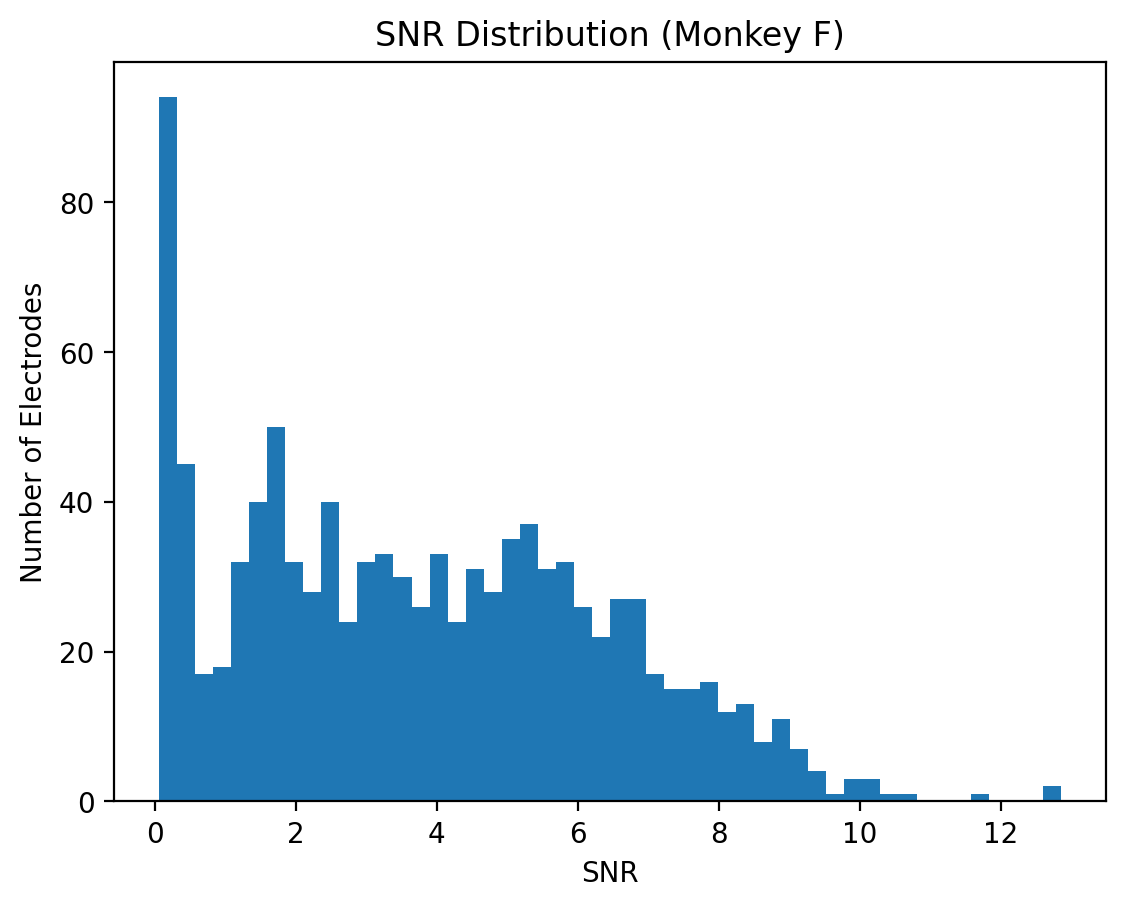

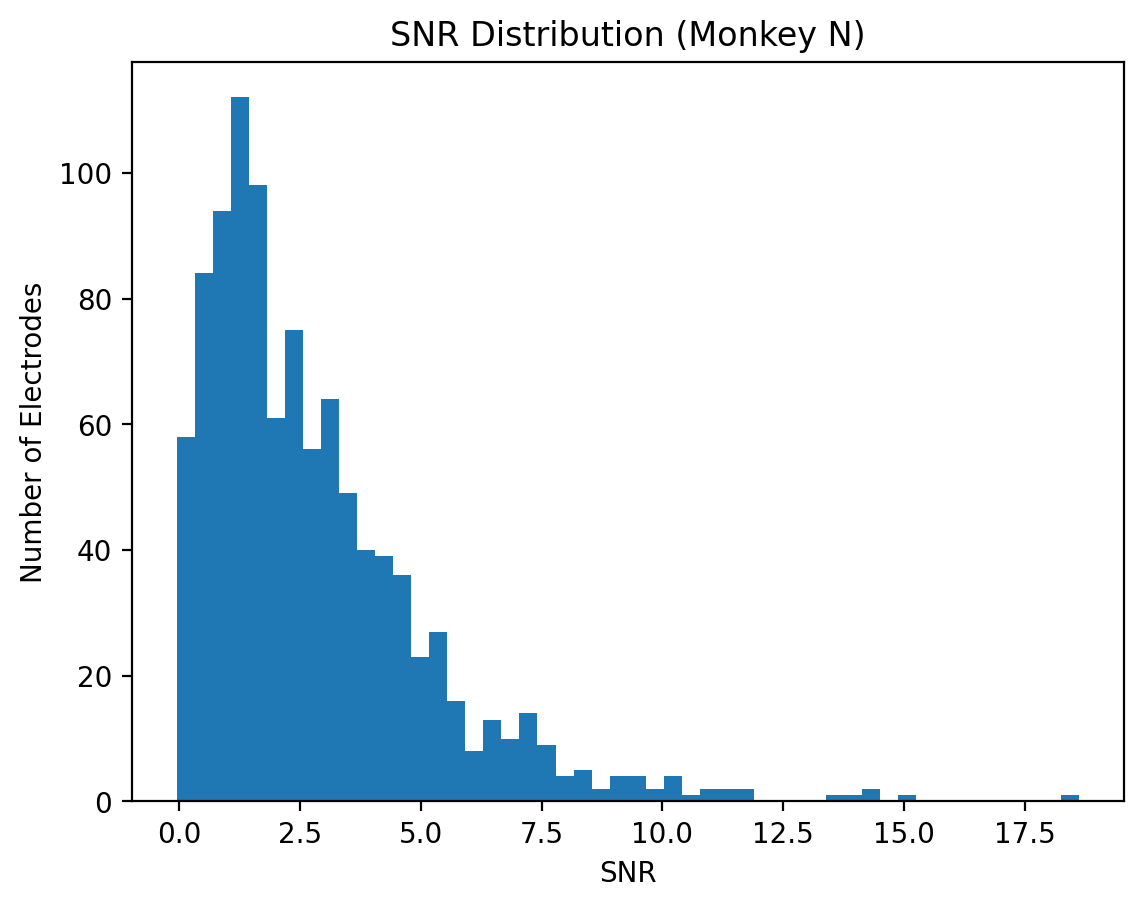

In [ ]:
import matplotlib.pyplot as plt

plt.hist(snrN_mean, bins=50)
plt.xlabel("SNR")
plt.ylabel("Number of Electrodes")
plt.title("SNR Distribution (Monkey F)")
plt.show()

plt.hist(snrF_mean, bins=50)
plt.xlabel("SNR")
plt.ylabel("Number of Electrodes")
plt.title("SNR Distribution (Monkey N)")
plt.show()


Processing Layers with Raw Pearson: 100%|██████████| 13/13 [00:41<00:00,  3.16s/layer]


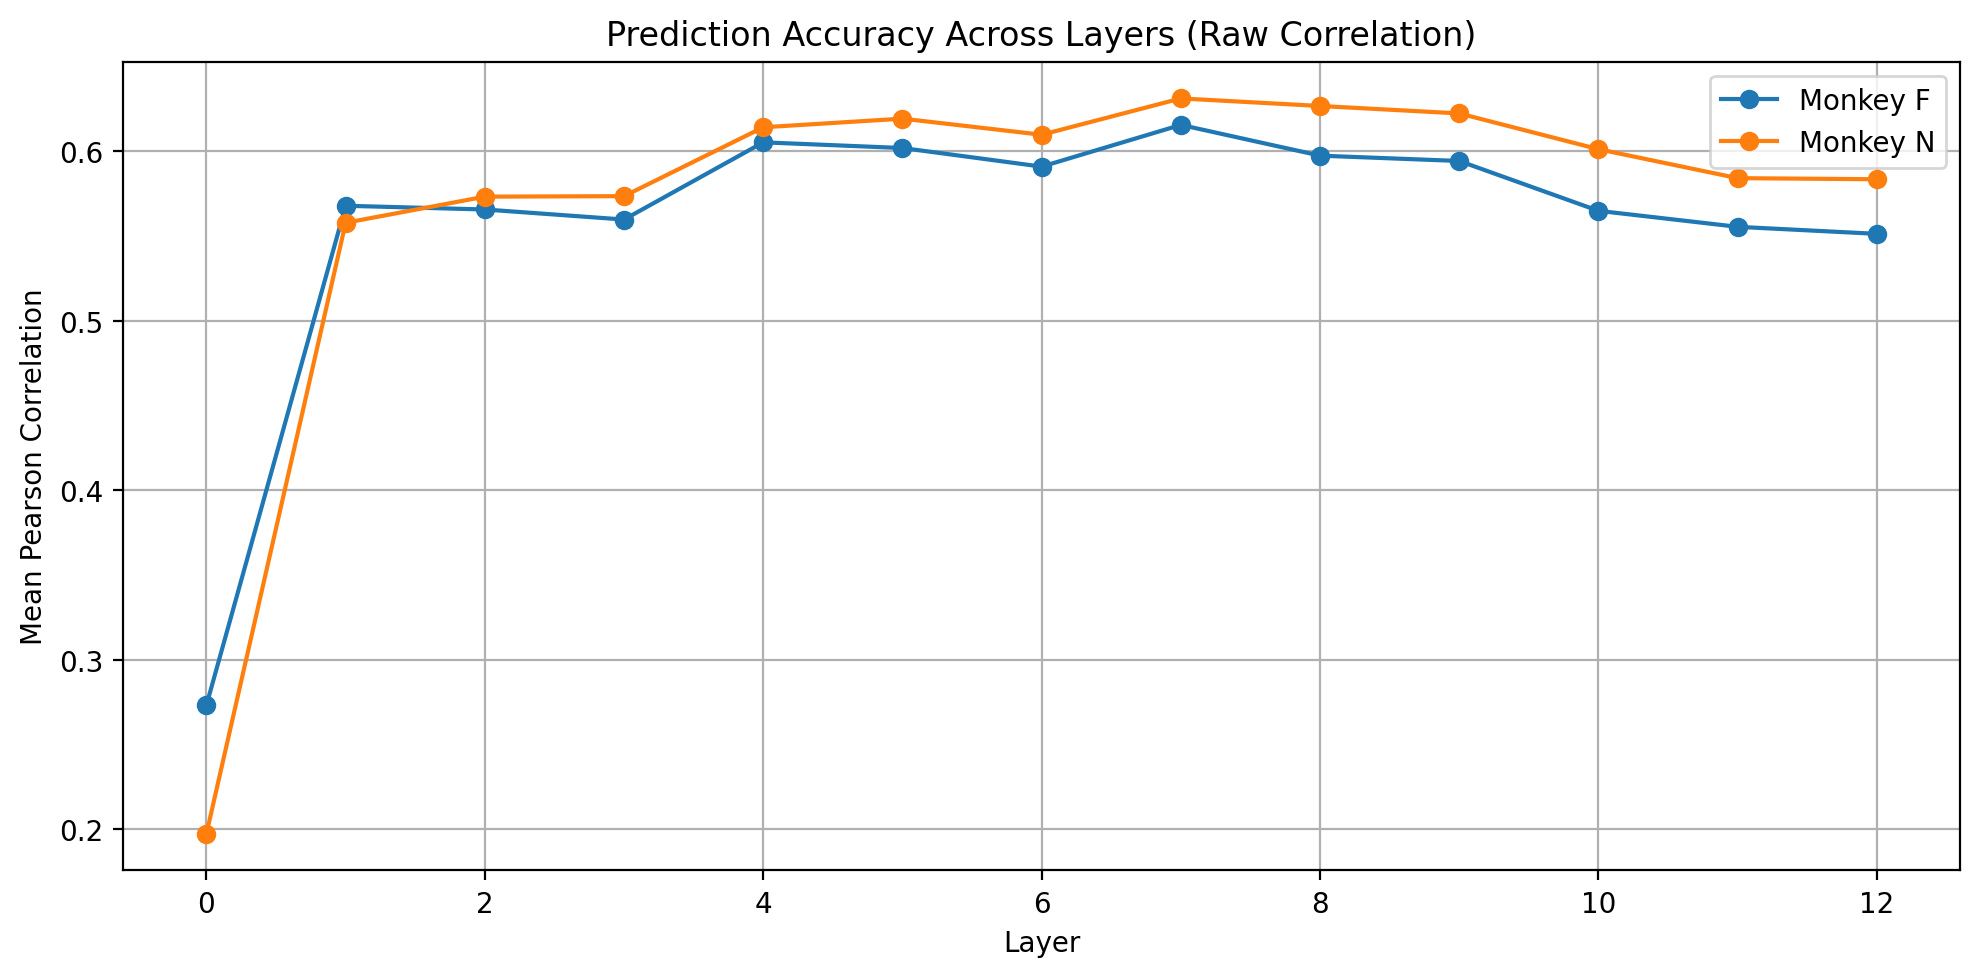

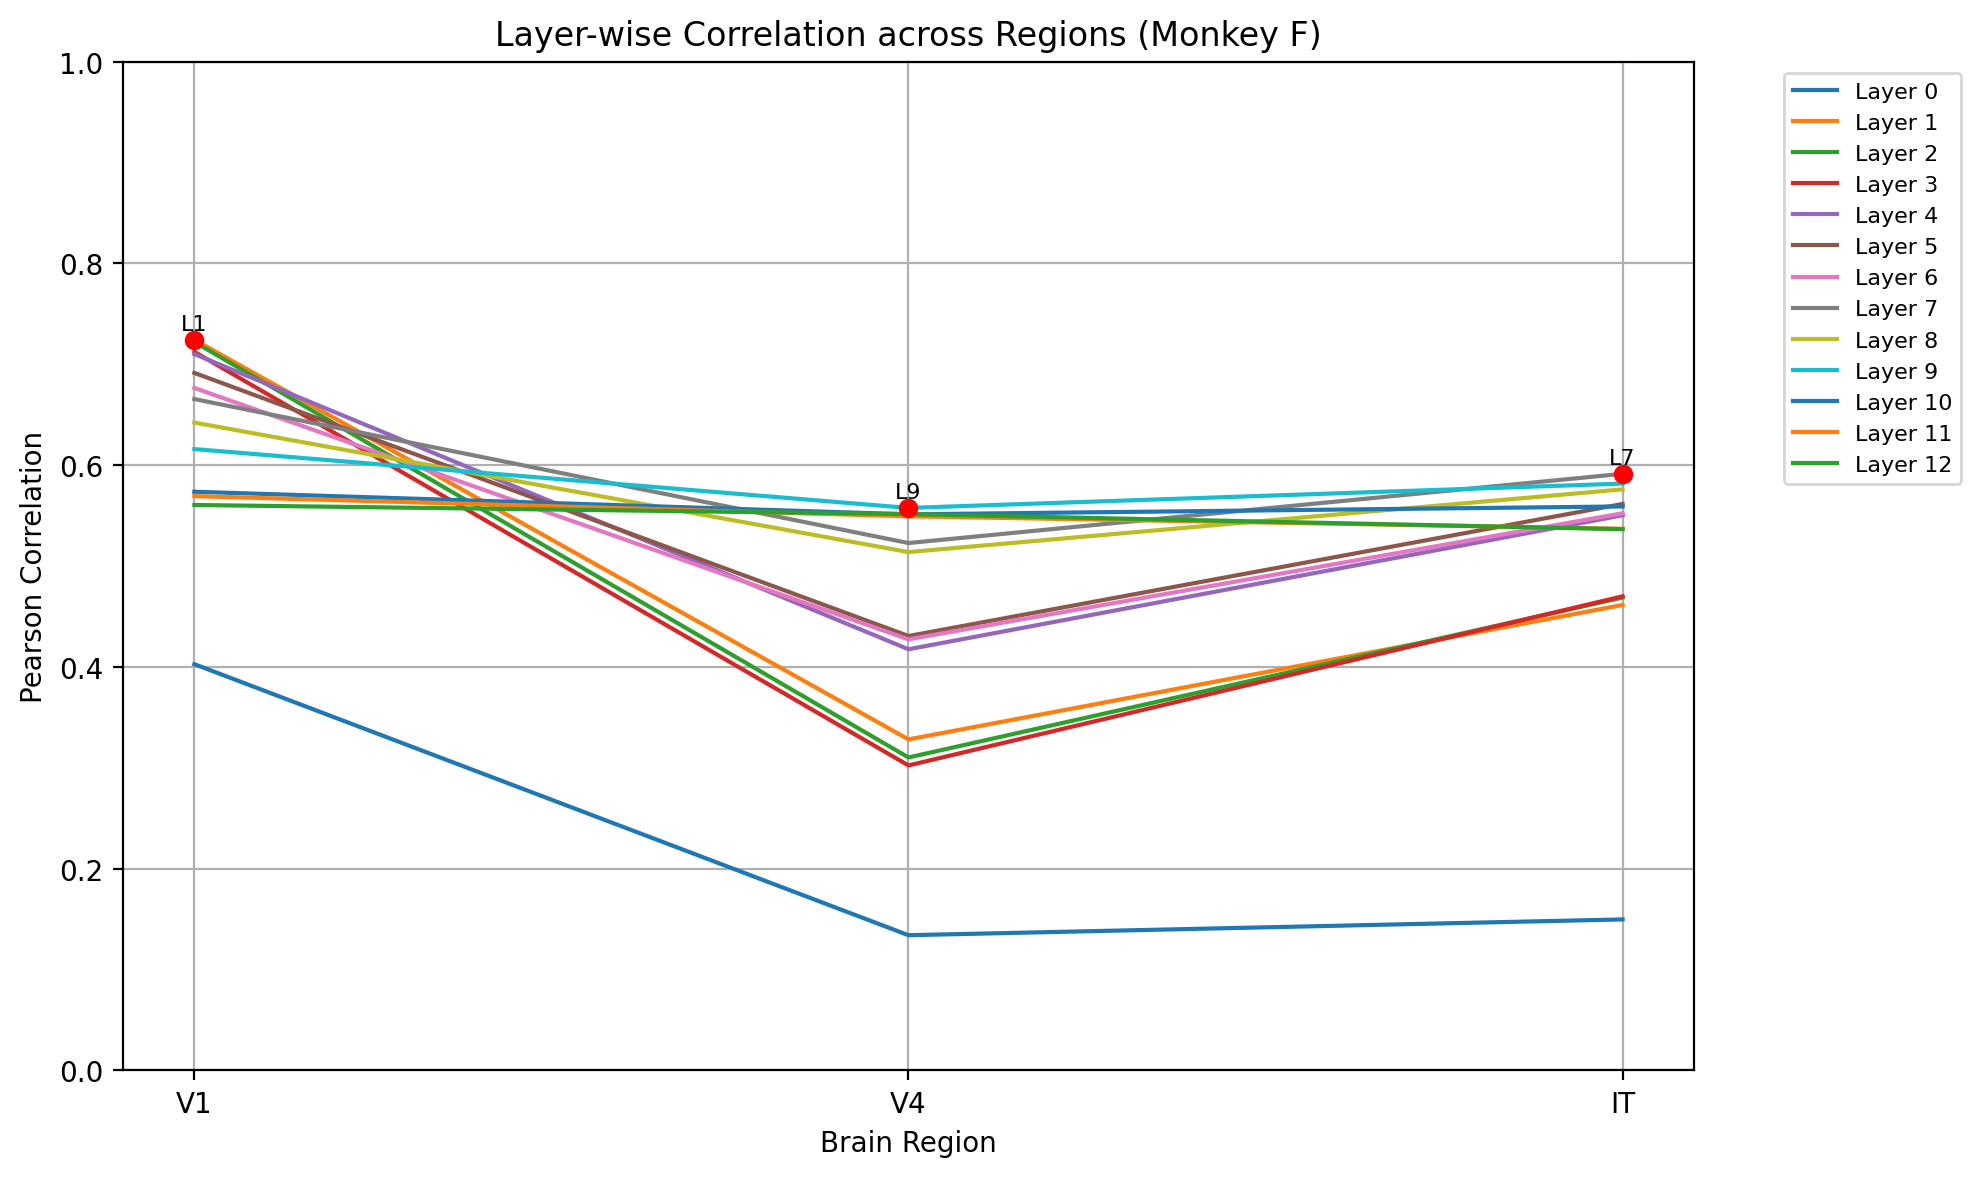

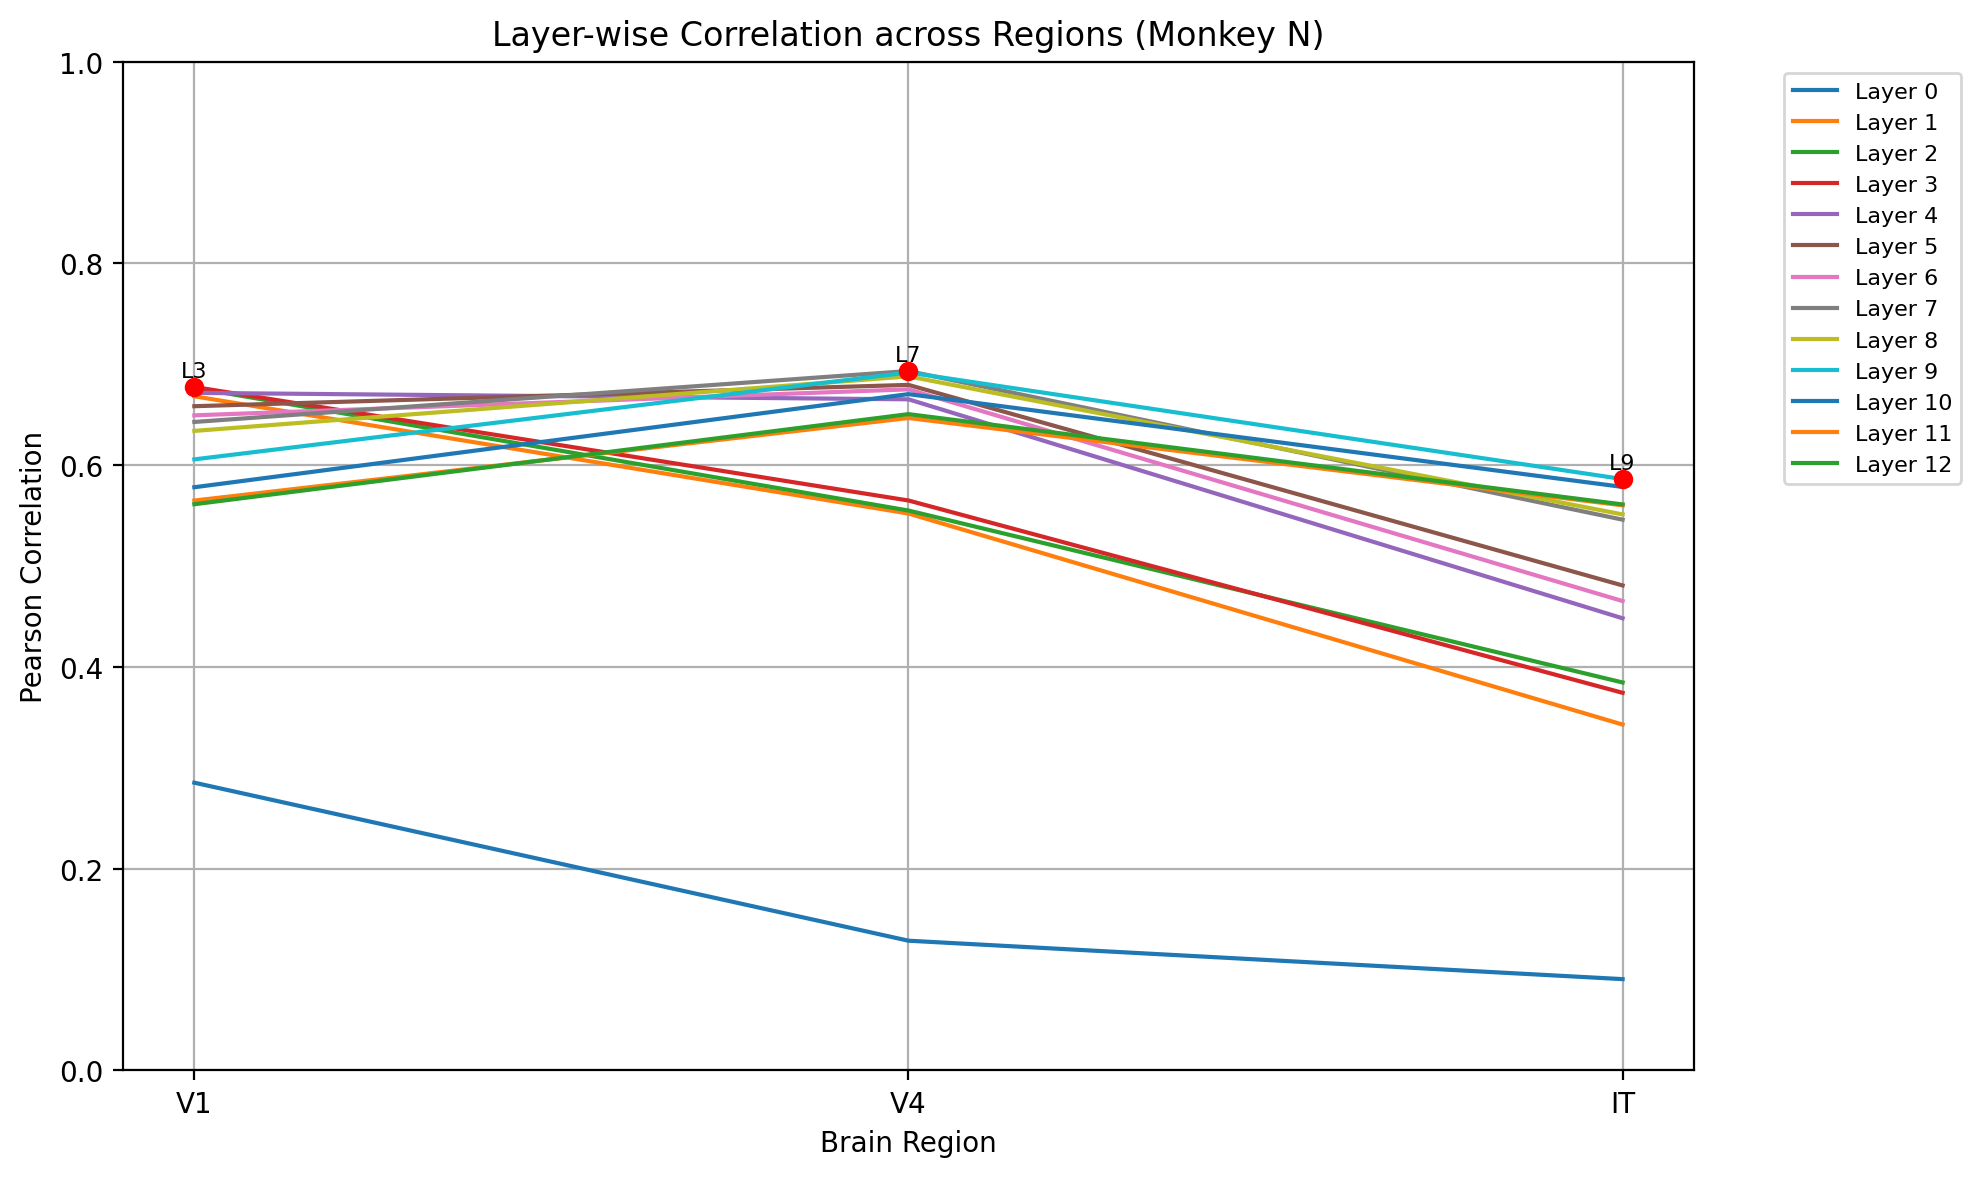

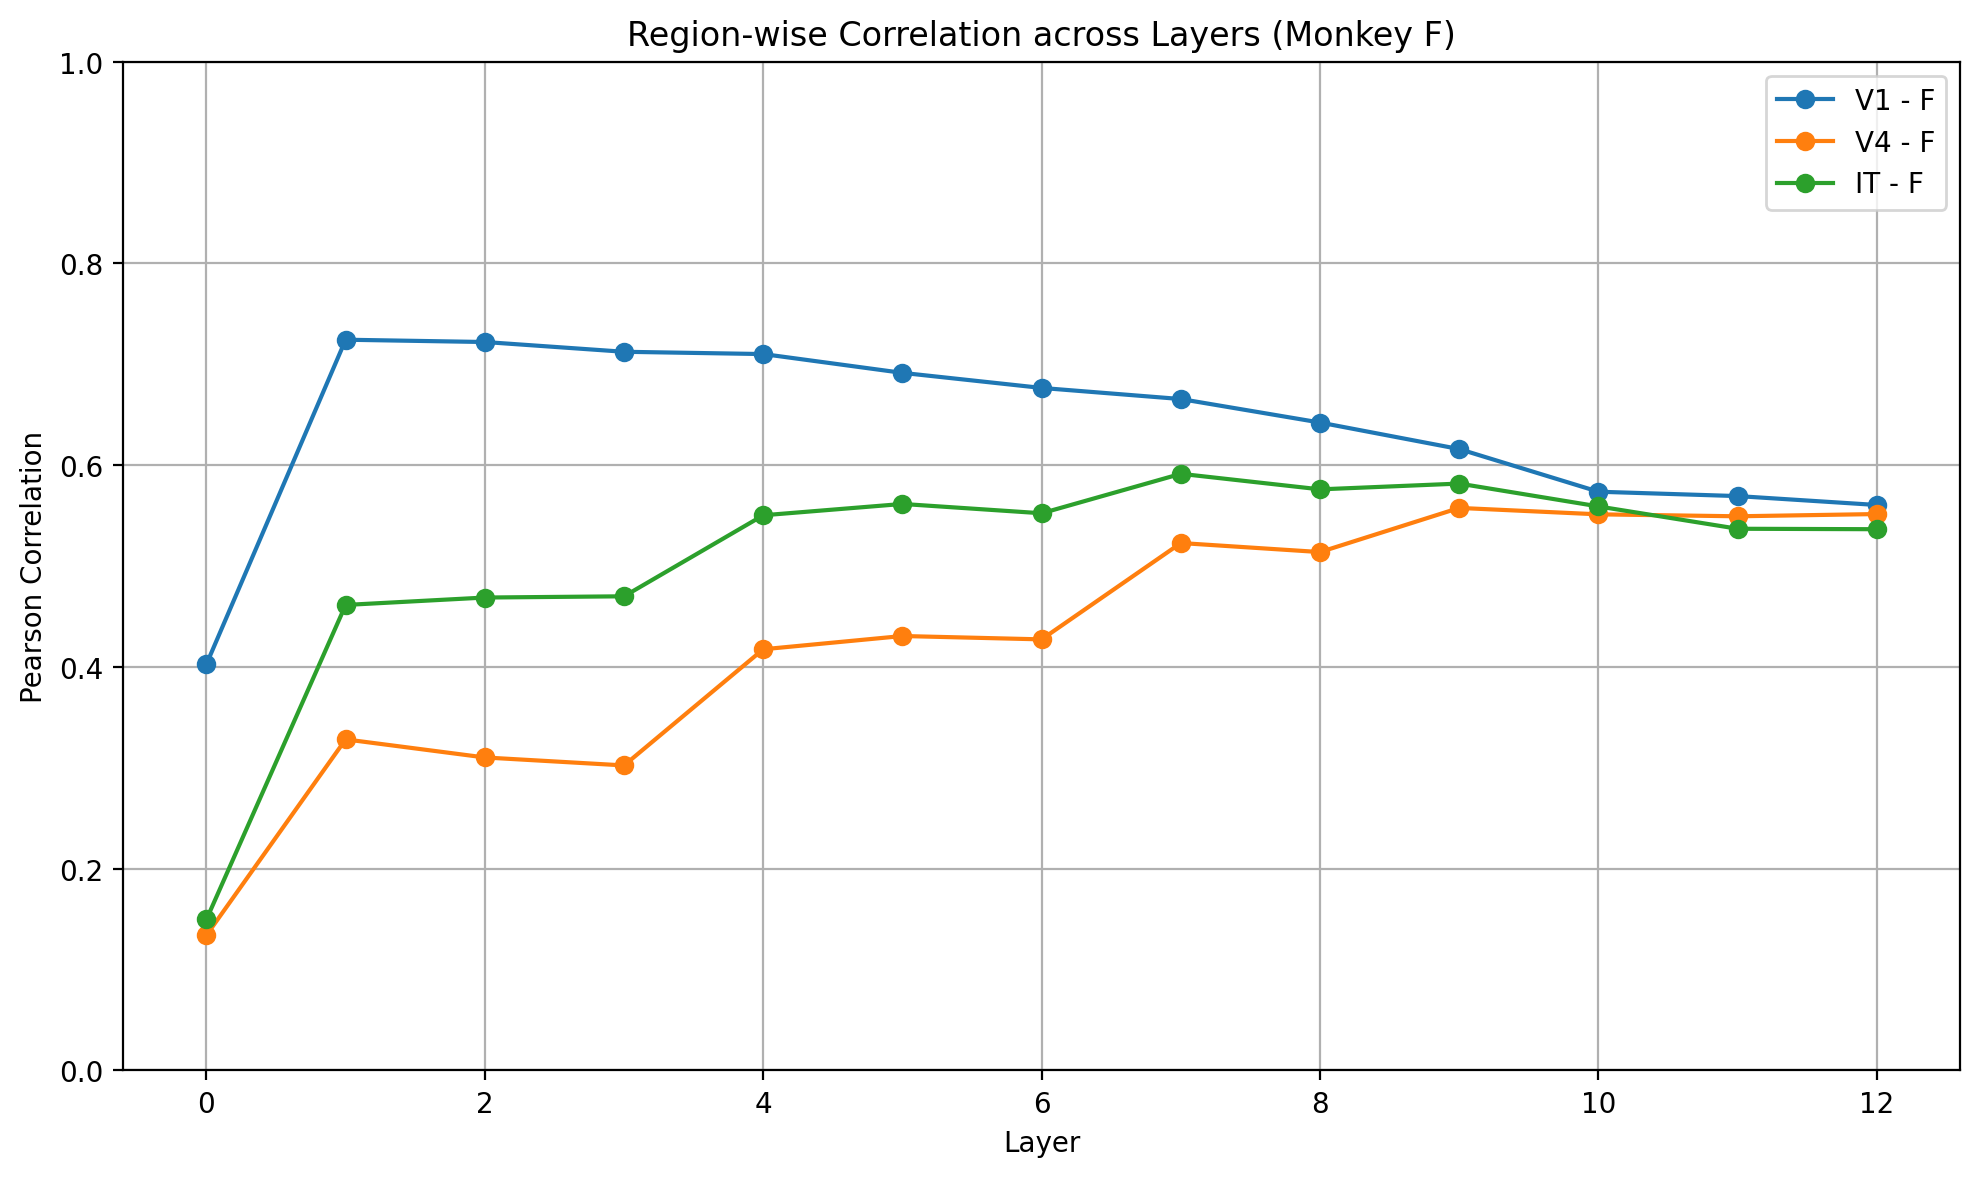

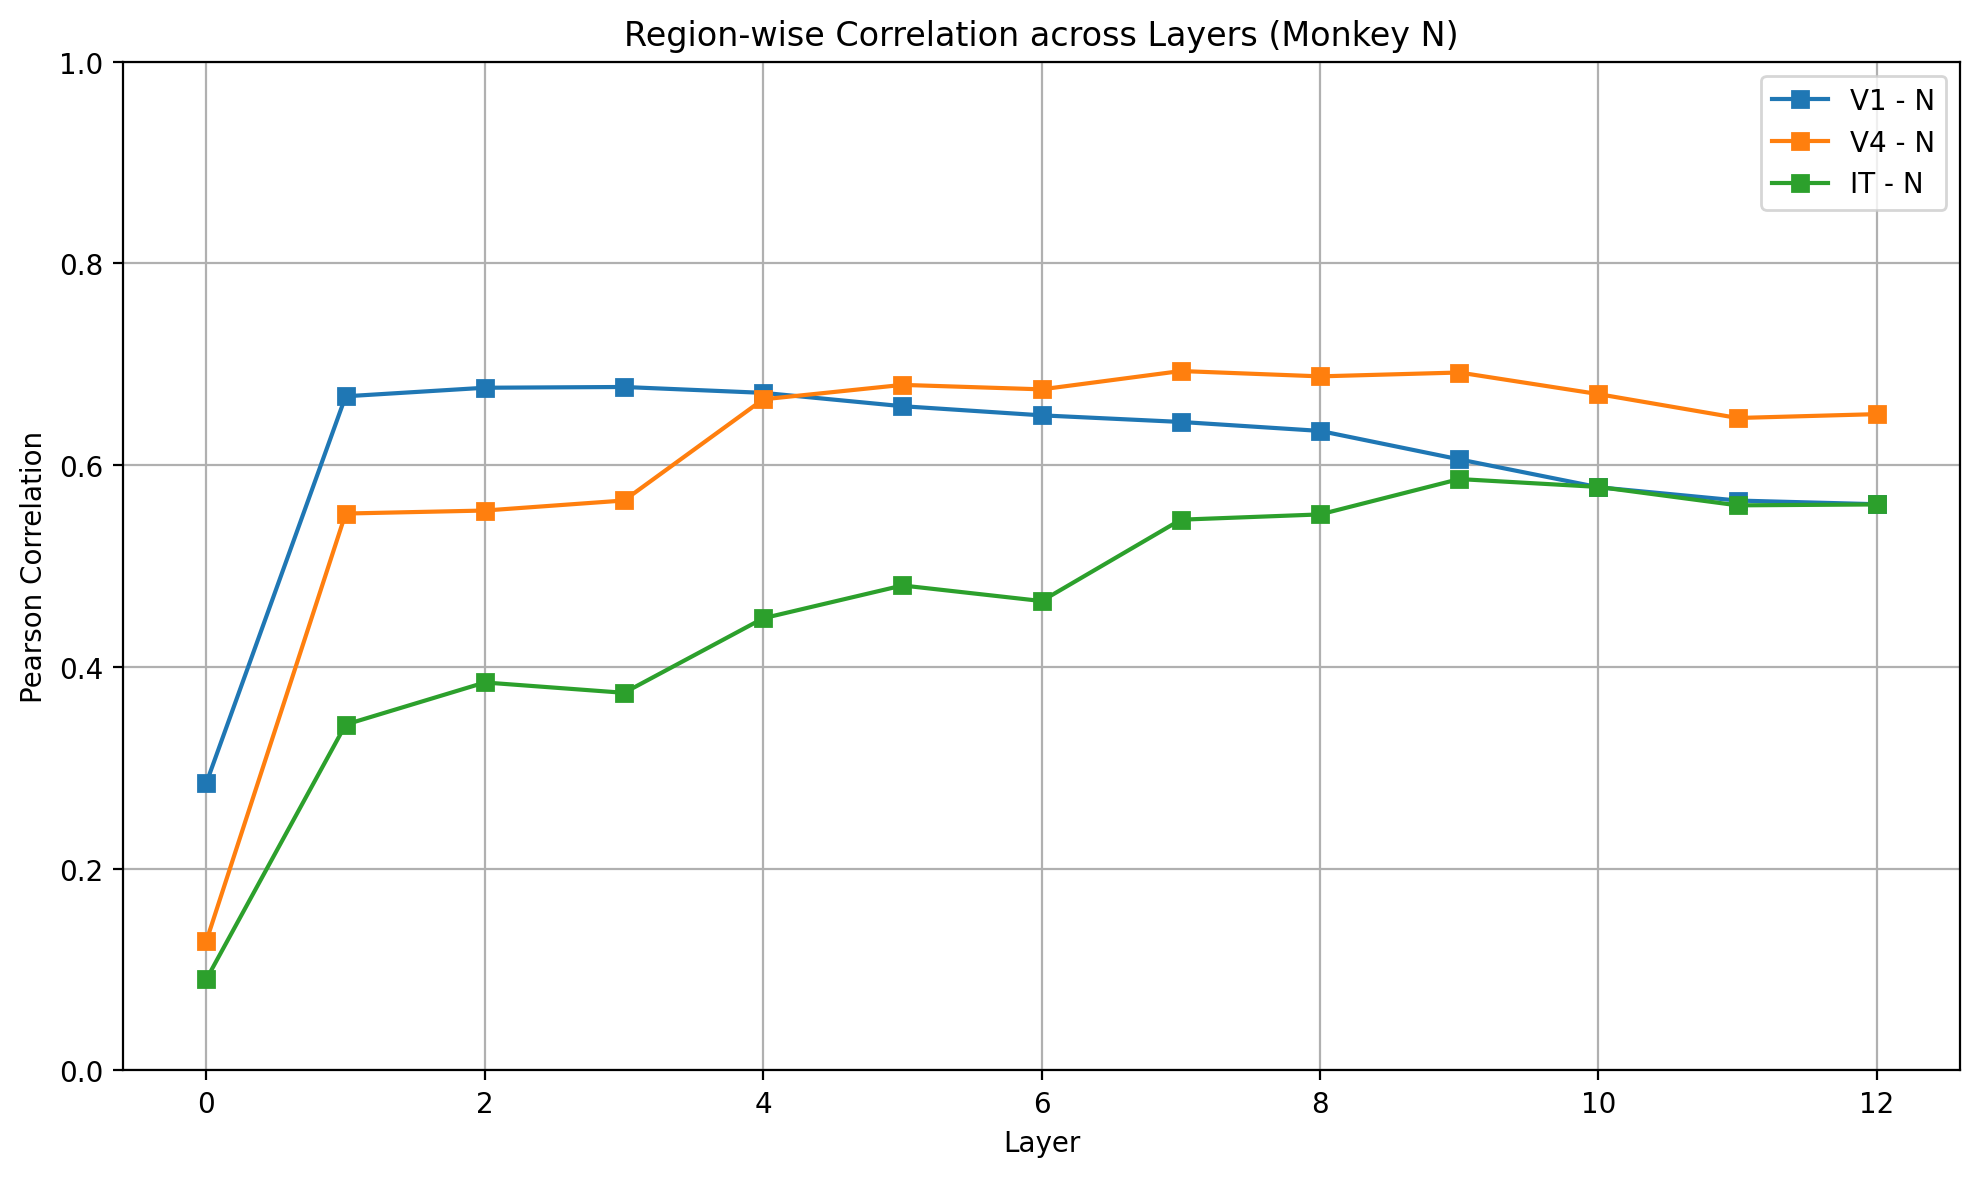

In [ ]:
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import joblib
import h5py

# ✅ Define model type and selected layers
model_type = "alexnet"
selected_layers = list(range(13))  # Layers 0 to 12

# Store raw correlation
mean_corr_F = {}
mean_corr_N = {}

# === Assign brain region labels using mapping (correct layout from original experiment)
rois_F = np.zeros(1024, dtype=int)
rois_F[512:704] = 1
rois_F[704:1024] = 2
rois_F = rois_F[mapping_flat]
region_labels_F = np.array(["V1", "V4", "IT"])
reordered_labels_F = region_labels_F[rois_F]

rois_N = np.ones(1024, dtype=int)
rois_N[512:768] = 2
rois_N[768:1024] = 3
rois_N = rois_N[mapping_flat]
region_labels_N = np.array(["V1", "V4", "IT"])
reordered_labels_N = region_labels_N[rois_N - 1]

# ✅ Process each layer
for layer in tqdm(selected_layers, desc="Processing Layers with Raw Pearson", unit="layer"):

    model_F_path = f"/content/drive/MyDrive/saved/{model_type}/model/trained_models_F_{model_type}_layer{layer}.pkl"
    model_N_path = f"/content/drive/MyDrive/saved/{model_type}/model/trained_models_N_{model_type}_layer{layer}.pkl"
    if not os.path.exists(model_F_path) or not os.path.exists(model_N_path):
        print(f"⚠ Missing models for layer {layer}")
        continue

    models_F = joblib.load(model_F_path)
    models_N = joblib.load(model_N_path)

    test_features_pca = np.load(f"/content/drive/MyDrive/saved/{model_type}/pca/test_features_pca_{model_type}_layer{layer}.npz")["arr_0"]

    # Predict
    predicted_F = np.array([models_F[i].predict(test_features_pca) for i in range(1024)])
    predicted_N = np.array([models_N[i].predict(test_features_pca) for i in range(1024)])

    # Pearson correlation (raw)
    correlations_F = np.array([pearsonr(predicted_F[i], test_MUA_F.T[i])[0] for i in range(1024)])
    correlations_N = np.array([pearsonr(predicted_N[i], test_MUA_N[i])[0] for i in range(1024)])

    # Save mean correlation
    mean_corr_F[layer] = np.mean(correlations_F)
    mean_corr_N[layer] = np.mean(correlations_N)

# ✅ Final plot: layer-wise mean correlation
plt.figure(figsize=(10, 5))
plt.plot(mean_corr_F.keys(), mean_corr_F.values(), marker='o', label="Monkey F")
plt.plot(mean_corr_N.keys(), mean_corr_N.values(), marker='o', label="Monkey N")
plt.xlabel("Layer")
plt.ylabel("Mean Pearson Correlation")
plt.title("Prediction Accuracy Across Layers (Raw Correlation)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Additional plots (separated for Monkey F and Monkey N)

region_labels = ["V1", "V4", "IT"]
region_layer_corrs_F = {region: [] for region in region_labels}
region_layer_corrs_N = {region: [] for region in region_labels}
layer_region_corrs_F = {}
layer_region_corrs_N = {}

for layer in selected_layers:
    model_F_path = f"/content/drive/MyDrive/saved/{model_type}/model/trained_models_F_{model_type}_layer{layer}.pkl"
    model_N_path = f"/content/drive/MyDrive/saved/{model_type}/model/trained_models_N_{model_type}_layer{layer}.pkl"
    if not os.path.exists(model_F_path) or not os.path.exists(model_N_path):
        continue

    models_F = joblib.load(model_F_path)
    models_N = joblib.load(model_N_path)
    test_features_pca = np.load(f"/content/drive/MyDrive/saved/{model_type}/pca/test_features_pca_{model_type}_layer{layer}.npz")["arr_0"]

    predicted_F = np.array([models_F[i].predict(test_features_pca) for i in range(1024)])
    predicted_N = np.array([models_N[i].predict(test_features_pca) for i in range(1024)])
    correlations_F = np.array([pearsonr(predicted_F[i], test_MUA_F.T[i])[0] for i in range(1024)])
    correlations_N = np.array([pearsonr(predicted_N[i], test_MUA_N[i])[0] for i in range(1024)])

    layer_region_corrs_F[layer] = []
    layer_region_corrs_N[layer] = []

    for region in region_labels:
        mask_F = reordered_labels_F == region
        mask_N = reordered_labels_N == region
        region_layer_corrs_F[region].append(np.mean(correlations_F[mask_F]))
        region_layer_corrs_N[region].append(np.mean(correlations_N[mask_N]))
        layer_region_corrs_F[layer].append(np.mean(correlations_F[mask_F]))
        layer_region_corrs_N[layer].append(np.mean(correlations_N[mask_N]))

# ✅ Plot 1: each line is a layer, across V1/V4/IT (Monkey F)
plt.figure(figsize=(10, 6))
for layer in selected_layers:
    if layer in layer_region_corrs_F:
        plt.plot(region_labels, layer_region_corrs_F[layer], label=f"Layer {layer}", linestyle='-')
for i, region in enumerate(region_labels):
    best_layer = np.argmax([layer_region_corrs_F[layer][i] for layer in selected_layers])
    best_val = max([layer_region_corrs_F[layer][i] for layer in selected_layers])
    plt.scatter(region, best_val, color='red', zorder=5)
    plt.text(region, best_val + 0.01, f"L{best_layer}", ha='center', fontsize=8)
plt.xlabel("Brain Region")
plt.ylabel("Pearson Correlation")
plt.title("Layer-wise Correlation across Regions (Monkey F)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.ylim(0, 1)
plt.tight_layout()
plt.grid(True)
plt.show()

# ✅ Plot 1: each line is a layer, across V1/V4/IT (Monkey N)
plt.figure(figsize=(10, 6))
for layer in selected_layers:
    if layer in layer_region_corrs_N:
        plt.plot(region_labels, layer_region_corrs_N[layer], label=f"Layer {layer}", linestyle='-')
for i, region in enumerate(region_labels):
    best_layer = np.argmax([layer_region_corrs_N[layer][i] for layer in selected_layers])
    best_val = max([layer_region_corrs_N[layer][i] for layer in selected_layers])
    plt.scatter(region, best_val, color='red', zorder=5)
    plt.text(region, best_val + 0.01, f"L{best_layer}", ha='center', fontsize=8)
plt.xlabel("Brain Region")
plt.ylabel("Pearson Correlation")
plt.title("Layer-wise Correlation across Regions (Monkey N)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.ylim(0, 1)
plt.tight_layout()
plt.grid(True)
plt.show()

# ✅ Plot 2: region-wise correlation across layers (Monkey F)
plt.figure(figsize=(10, 6))
for region in region_labels:
    plt.plot(selected_layers[:len(region_layer_corrs_F[region])], region_layer_corrs_F[region], marker='o', label=f"{region} - F")
plt.xlabel("Layer")
plt.ylabel("Pearson Correlation")
plt.title("Region-wise Correlation across Layers (Monkey F)")
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Plot 2: region-wise correlation across layers (Monkey N)
plt.figure(figsize=(10, 6))
for region in region_labels:
    plt.plot(selected_layers[:len(region_layer_corrs_N[region])], region_layer_corrs_N[region], marker='s', label=f"{region} - N")
plt.xlabel("Layer")
plt.ylabel("Pearson Correlation")
plt.title("Region-wise Correlation across Layers (Monkey N)")
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()
